# Nepal Deforestation Analysis — Notebook

**Author:** `Prayag Man Mane`  
**Date:** `2025-09`  

**Purpose:**  
Reproducible pipeline to:  
1. Quantify forest change in Nepal.  
2. Build and compare segmentation models to detect deforestation.  
3. Generate maps and results.

**How to run:**  
- Works in Google Colab or local Jupyter.  
- Run cells in order, starting below.  
- Authenticate Google Earth Engine and Google Drive when prompted.

## 1. Environment Setup

This section ensures the notebook runs both on **Google Colab** and **local Jupyter notebooks**.

We will:  
1. Detect environment (Colab or local).  
2. Install dependencies (if running in Colab).  
3. Import libraries and check versions.  
4. Create project directories (data, figures, models).  
5. Set random seeds for reproducibility.  
6. Authenticate and initialize Google Earth Engine (with project ID).  

---

### 1.1: Environment Detection

- Detect whether we are running inside **Google Colab** or **local Jupyter**.  
- Mount Google Drive if in Colab (to persist files).  
- Define a root project directory accordingly.  

In [1]:
import sys

IN_COLAB = 'google.colab' in sys.modules
print("Running on:", "Colab" if IN_COLAB else "Local Jupyter")

if IN_COLAB:
    from google.colab import drive, userdata
    drive.mount('/content/drive', force_remount=False)
    PROJECT_ROOT = '/content/drive/MyDrive/NEPAL_DEFORESTATION'
else:
    PROJECT_ROOT = './nepal_deforestation'

print("Project root directory:", PROJECT_ROOT)


Running on: Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project root directory: /content/drive/MyDrive/NEPAL_DEFORESTATION


### 1.2: Install Dependencies (Colab only)

- Install required packages if using Colab.  
- Skip this step for Jupyter/local where packages should already be installed.

In [2]:
# --- Install required packages (Colab only) ---
if IN_COLAB:
    !pip install -q earthengine-api geemap rasterio torch torchvision scikit-learn matplotlib pandas



### 1.3 Import Libraries & Check Versions

- Import core libraries: `numpy`, `pandas`, `matplotlib`, etc.  
- Import geospatial libraries: `earthengine-api`, `geemap`, `rasterio`.  
- Import ML libraries: `torch`, `scikit-learn`.  
- Print version info for reproducibility.

In [3]:
# --- Imports & version check ---
import os, platform, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import torch
import sklearn
import ee, geemap
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from IPython.display import display, Markdown
import json

print("Python:", platform.python_version())
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("rasterio:", rasterio.__version__)
print("torch:", torch.__version__)
print("scikit-learn:", sklearn.__version__)
print("geemap:", geemap.__version__)
print("earthengine-api:", ee.__version__)
print("torch:", torch.__version__)


Python: 3.12.11
numpy: 2.0.2
pandas: 2.2.2
rasterio: 1.4.3
torch: 2.8.0+cu126
scikit-learn: 1.6.1
geemap: 0.35.3
earthengine-api: 1.5.24
torch: 2.8.0+cu126


### 1.4: Project Structure

We create consistent directories for:  
- `data/` → raw and processed datasets.  
- `figures/` → visualizations and plots.  
- `models/` → saved ML models.  

This ensures reproducibility and portability across environments.

We fix random seeds across `numpy`, `torch`, and Python’s `random` module.  
If CUDA is available, GPU seeds are also fixed.  

In [4]:
# --- Project folders & reproducibility ---
from pathlib import Path

PROJECT_DIR = Path(PROJECT_ROOT)
DATA_DIR = PROJECT_DIR / "data"
FIG_DIR  = PROJECT_DIR / "figures"
MODEL_DIR = PROJECT_DIR / "models"

for d in [DATA_DIR, FIG_DIR, MODEL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Folders ready:", [str(d) for d in [DATA_DIR, FIG_DIR, MODEL_DIR]])

Folders ready: ['/content/drive/MyDrive/NEPAL_DEFORESTATION/data', '/content/drive/MyDrive/NEPAL_DEFORESTATION/figures', '/content/drive/MyDrive/NEPAL_DEFORESTATION/models']


### 1.5: Google Earth Engine Authentication & Project Setup

To run Earth Engine exports, you **must provide a GCP project ID** that has billing enabled.

- **In Google Colab**  
  1. Go to **"Secrets"** (🔑  in left sidebar).  
  2. Add a new secret with key: `GCP_PROJECT_ID` and value: `<your-project-id>`.  
  3. This notebook will automatically read it.

- **In Jupyter / Local**  
  1. Create a `.env` file in your project root.  
  2. Add the line:  
     ```
     GCP_PROJECT_ID=your-project-id
     ```
  3. The notebook will load it using `python-dotenv`.

If no project ID is provided, Earth Engine may still run, but **exports will fail** if billing is required.


In [5]:
# --- Authenticate & initialize Earth Engine with project_id ---

import os, sys
import ee

project_id = None

# Case 1: Running in Colab → use colab userdata secrets
if 'google.colab' in sys.modules:
    try:
        from google.colab import userdata
        project_id = userdata.get("GCP_PROJECT_ID")
        print("Loaded project_id from Colab secrets.")
    except Exception:
        print("⚠️ Could not load from Colab secrets. Set it manually using:")
        print("  from google.colab import userdata; userdata.set('GCP_PROJECT_ID','your-project-id')")

# Case 2: Running locally → load from .env file
else:
    try:
        from dotenv import load_dotenv
        load_dotenv()
        project_id = os.getenv("GCP_PROJECT_ID")
        if project_id:
            print("Loaded project_id from .env file.")
    except ImportError:
        print("⚠️ Install python-dotenv with `pip install python-dotenv` to load from .env.")

# Final fallback
if not project_id:
    print("⚠️ No GCP_PROJECT_ID provided. You may not be able to export.")

# Initialize Earth Engine
try:
    ee.Initialize(project=project_id)
    print("✅ Earth Engine initialized with project:", project_id)
except Exception:
    ee.Authenticate()
    ee.Initialize(project=project_id)
    print("✅ Earth Engine authenticated & initialized with project:", project_id)


Loaded project_id from Colab secrets.


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


✅ Earth Engine authenticated & initialized with project: earthengine-469607


## 2. Analyze Forest Dataset in Nepal (2000-2024)

1. Load the Nepal boundary (AOI) and Hansen dataset.
2. Clip forest cover, loss, and gain layers to Nepal.
3. Visualize tree cover, forest loss, and gain on an interactive map.
4. Compute forest area statistics for 2000 and total loss/gain.
5. Analyze the FarWest region separately, including maps and summary tables.

### 2.1: Nepal-wide Forest Analysis

**Objectives:**

- Define Nepal AOI using the FAO GAUL Level 0 dataset.  
- Load Hansen Global Forest Change dataset (2024 v1.12).  
- Clip tree cover, loss, and gain layers to Nepal.  


In [6]:
# --- Load Nepal boundary (AOI) ---
# Source: FAO GAUL (Global Administrative Units) Level 0 dataset on GEE
nepal_aoi = ee.FeatureCollection("FAO/GAUL/2015/level0") \
                .filter(ee.Filter.eq('ADM0_NAME', 'Nepal'))

# Quick info
print("Nepal AOI loaded.")

# --- Load Hansen Global Forest Change ---
hansen = ee.Image("UMD/hansen/global_forest_change_2024_v1_12")

treecover2000 = hansen.select(["treecover2000"])

loss = hansen.select("loss")
# gain = hansen.select("gain")

lossyear = hansen.select("lossyear")

# Clip to AOI
treecover2000 = treecover2000.clip(nepal_aoi)
loss = loss.clip(nepal_aoi)
lossyear = lossyear.clip(nepal_aoi)

print("Hansen dataset clipped to Nepal.")


Nepal AOI loaded.
Hansen dataset clipped to Nepal.


### 2.2: — Hansen Global Forest Change Dataset & Visualization

- Load `UMD/hansen/global_forest_change_2024_v1_12`.  
- Extract bands: `treecover2000`, `loss`, `gain`, `lossyear`.  
- Clip each band to Nepal AOI.  
- Define visualization parameters:
  - Treecover → gradient palette (light → dark green/blue).  
  - Loss → red.  
- Display tree cover (2000), forest loss, and gain layers.  
- Add AOI boundary for reference.  
- `.selfMask()` is used for cleaner overlay.

In [7]:
# --- Visualization parameters ---
vis_params = {
    'bands': ['treecover2000'],
    'min': 0,
    'max': 100,
    'palette': ['#ffffd9', '#edf8b1', '#c7e9b4', '#7fcdbb', '#41b6c4', '#1d91c0', '#225ea8', '#0c2c84']
}

loss_vis_params = {
    'palette': ['#FF0000'] # Bright Red
}


# Show in interactive map
Map = geemap.Map(center=[28.2, 84.0], zoom=7)

# Add the tree cover layer to the map, clipping it to Nepal's borders
Map.addLayer(
    treecover2000.selfMask().clip(nepal_aoi), # Clip the image to our AOI
    vis_params,                     # Apply our visualization style
    'Tree Cover in 2000'            # Name the layer
)

# Border style
Map.addLayer(nepal_aoi.style(**{'color': 'black', 'fillColor': '00000000'}), {}, 'Nepal Border')

# Add the masked loss layer to our existing map object
Map.addLayer(
    loss.selfMask().clip(nepal_aoi), #  .selfMask() to make all '0' pixels transparent ensures that we only see the pixels where loss actually occurred.
    loss_vis_params,
    'Forest Loss (2000-2024)'
)

# Map.addLayer(gain, gain_vis, "Forest Gain (2001-2024)")
Map



Map(center=[28.2, 84.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

### 2.3: Forest Area Statistics

- Calculate **total forest area in 2000** using canopy cover threshold (≥30%).  
- Calculate **total forest loss** and **percentage loss** from 2001–2024.  
- Generate **yearly forest loss statistics** for plotting.  
- Bar chart shows **annual forest loss (m²)** from 2001–2024.


In [8]:
# --- Compute forest area stats in m² ---

# Forest cover threshold (percent canopy)
CANOPY_COVER_THRESHOLD = 30

# Mask forest areas in 2000
forest_2000 = treecover2000.gte(CANOPY_COVER_THRESHOLD)

# Mask forest loss (only where it was forest in 2000)
forest_loss = forest_2000.And(loss.eq(1))

# Pixel area in m²
pixel_area_m2 = ee.Image.pixelArea()

# Forest area
forest_area_m2 = forest_2000.multiply(pixel_area_m2)
forest_area_stats = forest_area_m2.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=nepal_aoi.geometry(),
    scale=30,
    maxPixels=1e13
)
forest_area_m2_val = forest_area_stats.get('treecover2000').getInfo()

# Forest loss area
loss_area_m2 = forest_loss.multiply(pixel_area_m2)
loss_area_stats = loss_area_m2.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=nepal_aoi.geometry(),
    scale=30,
    maxPixels=1e13
)
loss_area_m2_val = loss_area_stats.get('treecover2000').getInfo()

# Percentage loss
percentage_loss = (loss_area_m2_val / forest_area_m2_val) * 100

# Print results
print(f"Forest cover (2000, >{CANOPY_COVER_THRESHOLD}% canopy): {forest_area_m2_val:,.0f} m²")
print(f"Forest loss (2001–2024): {loss_area_m2_val:,.0f} m²")
print(f"Percentage loss: {percentage_loss:.2f}%")

Forest cover (2000, >30% canopy): 51,671,377,832 m²
Forest loss (2001–2024): 583,296,015 m²
Percentage loss: 1.13%


In [9]:
# --- Compute yearly forest loss in m² (2001-2024) ---

years = list(range(2001, 2025))  # 2001 to 2024
loss_per_year_m2 = []

# Loop through each year
for i, year in enumerate(years, start=1):  # Hansen "lossyear": 1 = 2001
    # Mask pixels lost in this year AND were forest in 2000
    loss_year_mask = forest_2000.And(lossyear.eq(i))

    # Calculate area in m²
    loss_year_area_m2 = loss_year_mask.multiply(pixel_area_m2).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=nepal_aoi.geometry(),
        scale=30,
        maxPixels=1e13
    )

    # Extract value safely
    area_val = loss_year_area_m2.get('treecover2000').getInfo()
    loss_per_year_m2.append(area_val if area_val else 0)

# Convert to pandas DataFrame for plotting
import pandas as pd

loss_df = pd.DataFrame({
    "Year": years,
    "Forest Loss (m²)": loss_per_year_m2
})

print(loss_df.head())


   Year  Forest Loss (m²)
0  2001      1.515899e+07
1  2002      2.142191e+07
2  2003      2.294871e+07
3  2004      2.482721e+07
4  2005      2.760597e+07


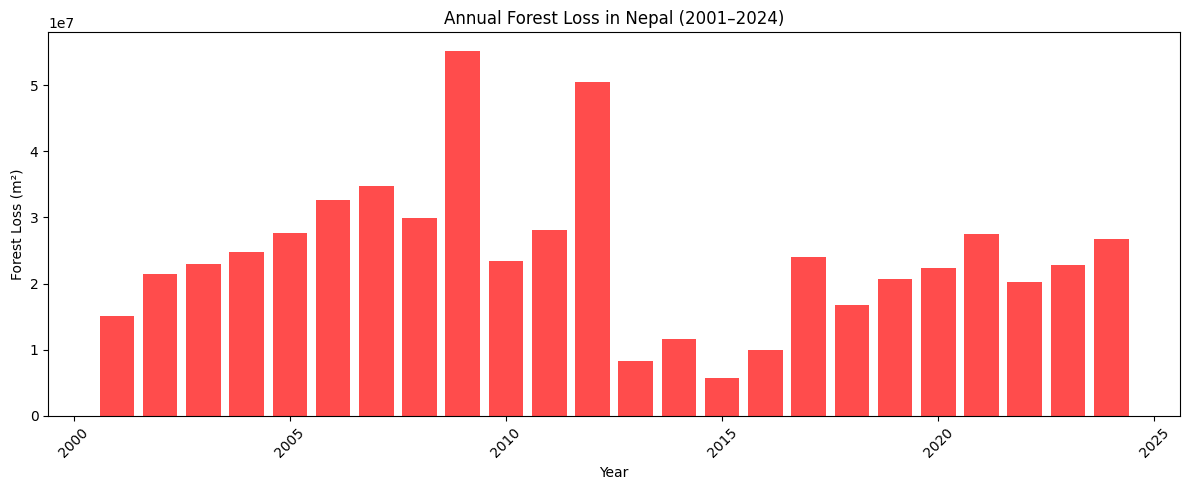

In [10]:
plt.figure(figsize=(12,5))
plt.bar(loss_df["Year"], loss_df["Forest Loss (m²)"], color='red', alpha=0.7)
plt.title("Annual Forest Loss in Nepal (2001–2024)")
plt.xlabel("Year")
plt.ylabel("Forest Loss (m²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.4: FarWest Region Forest Analysis

**Objectives:**

- FAO GAUL Level 1 dataset used for administrative boundaries.  
- Filter to select **Far Western Region of Nepal**.  
- AOI used for all subsequent area calculations and maps.



In [11]:
#  Define FarWest AOI
admin_lvl_1 = ee.FeatureCollection("FAO/GAUL/2015/level1")
farwest_aoi = admin_lvl_1.filter(ee.Filter.And(
    ee.Filter.eq('ADM0_NAME', 'Nepal'),
    ee.Filter.eq('ADM1_NAME', 'Far Western')
))
farwest_geom = farwest_aoi.geometry()  # Geometry for calculations


### 2.5: Forest, Loss, and Gain Masks

- Forest mask: `treecover2000 ≥ 30%`.  
- Forest loss mask: only areas that were forest in 2000 and lost since then.  
- Forest gain mask: areas that gained forest since 2000.  
- Masks will be used for **area calculations** and **visualization**.


In [12]:
# Load Hansen Global Forest Change dataset
gfc = ee.Image('UMD/hansen/global_forest_change_2024_v1_12')
CANOPY_COVER_THRESHOLD = 30
pixel_area_m2 = ee.Image.pixelArea()

# Masks
is_forest_2000 = gfc.select('treecover2000').gte(CANOPY_COVER_THRESHOLD)
has_loss = gfc.select('loss').eq(1)
has_gain = gfc.select('gain').eq(1)

# Forest loss only in areas that were forest in 2000
actual_forest_loss = is_forest_2000.And(has_loss)


### 2.6: Area Calculations

- Compute forest area in 2000 (sq km).  
- Compute total forest loss and gain (sq km).  
- Calculate **net change** and **percentage change**.  
- Summary table provides a clean overview.


In [13]:
# Calculate areas in sq km
# Base forest area (2000)
farwest_base_area = is_forest_2000.multiply(pixel_area_m2).reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=farwest_geom,
    scale=30,
    maxPixels=1e9
).get('treecover2000').getInfo() / 1e6  # Convert m² → km²

# Forest loss area
farwest_loss_area = actual_forest_loss.multiply(pixel_area_m2).reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=farwest_geom,
    scale=30,
    maxPixels=1e9
).get('treecover2000').getInfo() / 1e6

# Forest gain area
farwest_gain_area = has_gain.multiply(pixel_area_m2).reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=farwest_geom,
    scale=30,
    maxPixels=1e9
).get('gain').getInfo() / 1e6

# Net change
farwest_net_change = farwest_gain_area - farwest_loss_area
farwest_final_area = farwest_base_area + farwest_net_change
farwest_net_percentage = (farwest_net_change / farwest_base_area) * 100


In [14]:
summary_df = pd.DataFrame({
    "Metric": [
        "Forest 2000 (sq km)",
        "Forest Loss (sq km)",
        "Forest Gain (sq km)",
        "Net Change (sq km)",
        "Final Forest Area (sq km)",
        "Net % Change"
    ],
    "Value": [
        farwest_base_area,
        farwest_loss_area,
        farwest_gain_area,
        farwest_net_change,
        farwest_final_area,
        farwest_net_percentage
    ]
})

summary_df


,Metric,Value
0,Forest 2000 (sq km),8934.378884
1,Forest Loss (sq km),98.744308
2,Forest Gain (sq km),20.336886
3,Net Change (sq km),-78.407422
4,Final Forest Area (sq km),8855.971462
5,Net % Change,-0.877592


### 2.6: Visualizations
 **Interactive map:** Overlay forest cover, loss, and gain for FarWest region.  
   - Forest → green  
   - Loss → red  
   - AOI border → black


In [15]:
# --- 6. Interactive Map (FarWest) using earlier palettes ---
map_farwest = geemap.Map(center=[28.5, 80.5], zoom=9)

# Forest cover 2000 → use same vis_params as Nepal
map_farwest.addLayer(is_forest_2000.selfMask().clip(farwest_geom), vis_params, 'Forest Cover 2000')

# Forest loss → reuse earlier loss_vis_params (red palette)
map_farwest.addLayer(actual_forest_loss.selfMask().clip(farwest_geom), loss_vis_params, 'Forest Loss')

# AOI border
map_farwest.addLayer(farwest_aoi.style(color='black', fillColor='00000000'), {}, 'FarWest Border')

map_farwest


Map(center=[28.5, 80.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

---
## 3. Deep Learning Data Preparation

With our foundational analysis complete, we now prepare the data for our deep learning models. This section covers the entire pipeline, from defining our data sources in Google Earth Engine to creating the final PyTorch DataLoaders that will feed the models during training.


### 3.1. Defining Data Sources in GEE

We will define two sets of input data for our comparative analysis: a baseline "static" image and an "enhanced" image that includes topographic data.



#### 3.1.1. Static Data (3-Class Problem)

Our first set of experiments will use a 4-channel satellite image as input. The goal is to train a model to predict a 3-class historical land cover map.

*   **Input Image (X):** A 4-channel image from a recent, cloud-free Sentinel-2 composite (Red, Green, Blue, Near-Infrared).
*   **Label Mask (y):** Our 3-class "ground truth" layer derived from the Hansen dataset: `0` for Stable Non-Forest, `1` for Stable Forest (since 2000), and `2` for Deforested Land.

In [16]:
# --- 3.1.1: Define Static Data Sources ---

# Define a recent, cloud-free Sentinel-2 image composite
s2_image_static = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                     .filterBounds(nepal_aoi)
                     .filterDate('2023-10-01', '2023-12-31')
                     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
                     .median()
                     .select(['B4', 'B3', 'B2', 'B8'])) # R, G, B, NIR

# Define the 3-class historical label
label_static = (ee.Image(0) # Start with class 0 (Non-Forest)
                .where(gfc.select('treecover2000').gte(30), 1) # Add class 1 (Forest)
                .where(gfc.select('treecover2000').gte(30).And(gfc.select('loss').eq(1)), 2) # Add class 2 (Deforested)
                .rename('label'))

print("Static 4-channel input image and 3-class label defined.")

Static 4-channel input image and 3-class label defined.


#### 3.1.2. Enhanced Data with Topography

To test our hypothesis that geographical context can improve model performance, we create an enhanced input image. We fuse the 4-channel Sentinel-2 imagery with 2 static topographic channels derived from a Digital Elevation Model (DEM).

*   **Enhanced Input Image (X):** A 6-channel image (R, G, B, NIR, Elevation, Slope).
*   **Label Mask (y):** The same 3-class label is used.

In [17]:
# --- 3.1.2: Define Enhanced Data Sources with Topography ---

# Load the Digital Elevation Model (DEM) and calculate slope
dem = ee.Image('USGS/SRTMGL1_003')
elevation = dem.select('elevation')
slope = ee.Terrain.slope(dem)

# Create the 6-channel input image by stacking all bands
input_image_with_topo = s2_image_static.addBands(elevation).addBands(slope)

print("Enhanced 6-channel input image created.")
print("Bands:", input_image_with_topo.bandNames().getInfo())

Enhanced 6-channel input image created.
Bands: ['B4', 'B3', 'B2', 'B8', 'elevation', 'slope']


### 3.2. Exporting Training Datasets

With our data sources defined, we now export the labeled image patches that will form our training datasets. The following cells are for this one-time, time-intensive data export. They use a "smart" resumable logic that checks for existing files and only exports the missing ones.

#### 3.2.1. Exporting Static Patches

These are the 5-band GeoTIFFs (4 input channels + 1 label) for our baseline experiments, saved to the `data/sat_patch` folder.

In [18]:
# Define Export Parameters ---
STATIC_FOLDER = '/content/drive/My Drive/NEPAL_DEFORESTATION/data/sat_patch'
if not os.path.exists(STATIC_FOLDER): os.makedirs(STATIC_FOLDER)
print(f"Exporting to static data folder: {STATIC_FOLDER}")

TOTAL_SAMPLES = 5000
PATCH_SIZE = 64
SCALE = 10
FILE_PREFIX = 'nepal_forest_patch'

# Check for Already Exported Files to prevent reduncancy
print("Checking for existing static files...")
try:
    existing_files = os.listdir(STATIC_FOLDER)
    existing_indices = {int(f.split('_')[-1].split('.')[0]) for f in existing_files if f.startswith(FILE_PREFIX)}
    print(f"Found {len(existing_indices)} files already exported.")
except FileNotFoundError:
    existing_indices = set()

# Generate and Fetch Sample Points
all_indices = set(range(TOTAL_SAMPLES))
missing_indices = sorted(list(all_indices - existing_indices))

if not missing_indices:
    print("\nStatic dataset export is already complete!")
else:
    print(f"\n{len(missing_indices)} files are missing. Preparing to generate points and launch export tasks.")

    # Generate ALL Potential Sample Points on the server
    sample_points = ee.FeatureCollection.randomPoints(
        region=nepal_aoi.geometry(),
        points=TOTAL_SAMPLES,
        seed=42
    )
    # Fetch ALL point geometries to the client
    print("Fetching all point geometries... (This may take a moment)")
    points_info = sample_points.getInfo()['features']
    print(f"Successfully fetched {len(points_info)} concrete point geometries.")

    # Define the export image
    export_image_static = s2_image_static.addBands(label_static).toFloat()

    # Export loop
    print(f"Launching {len(missing_indices)} new export tasks... This may take a while.")

    for i in missing_indices:
        feature = points_info[i]
        filename = f'{FILE_PREFIX}_{i:04d}'

        point_geometry = feature['geometry']

        export_region = ee.Geometry.Point(
            point_geometry['coordinates']).buffer(PATCH_SIZE * SCALE / 2).bounds()

        image_to_export = export_image_static.clip(export_region)

        task = ee.batch.Export.image.toDrive(
            image=image_to_export,
            description=f'Static_Export_{filename}',
            folder=os.path.basename(os.path.dirname(STATIC_FOLDER)),
            fileNamePrefix=f"{os.path.basename(STATIC_FOLDER)}/{filename}",
            region=export_region.getInfo()['coordinates'],
            scale=SCALE,
            fileFormat='GeoTIFF'
        )
        task.start()

    print(f"\nSuccessfully LAUNCHED {len(missing_indices)} new export tasks.")
    print("Please go to the GEE Tasks tab to monitor and run them.")

Exporting to static data folder: /content/drive/My Drive/NEPAL_DEFORESTATION/data/sat_patch
Checking for existing static files...
Found 5000 files already exported.

Static dataset export is already complete!


#### 3.2.2. Exporting Topo-Enhanced Patches

These are the 7-band GeoTIFFs (6 input channels + 1 label) for our advanced model experiments, saved to the `data/sat_patch_topo` folder.

In [19]:
# Export Parameters
TOPO_FOLDER = '/content/drive/My Drive/NEPAL_DEFORESTATION/data/sat_patch_topo'
if not os.path.exists(TOPO_FOLDER): os.makedirs(TOPO_FOLDER)
print(f"Exporting to topo-enhanced data folder: {TOPO_FOLDER}")

TOTAL_SAMPLES = 5000
PATCH_SIZE = 64
SCALE = 10
FILE_PREFIX = 'nepal_topo_patch' # unique prefix for this dataset

# Check for Already Exported Files
print("Checking for existing topo-enhanced files...")
try:
    existing_files = os.listdir(TOPO_FOLDER)
    existing_indices = {int(f.split('_')[-1].split('.')[0]) for f in existing_files if f.startswith(FILE_PREFIX)}
    print(f"Found {len(existing_indices)} files already exported.")
except FileNotFoundError:
    existing_indices = set()

# Generate and Fetch Sample Points
all_indices = set(range(TOTAL_SAMPLES))
missing_indices = sorted(list(all_indices - existing_indices))

if not missing_indices:
    print("\nTopo-enhanced dataset export is already complete!")
else:
    print(f"\n{len(missing_indices)} files are missing. Preparing to generate points and launch export tasks.")

    # Generate ALL Potential Sample Points on the server
    # We use the same points as the static export for a fair comparison
    sample_points = ee.FeatureCollection.randomPoints(
        region=nepal_aoi.geometry(),
        points=TOTAL_SAMPLES,
        seed=42
    )
    # Fetch ALL point geometries to the client
    print("Fetching all point geometries... (This may take a moment)")
    points_info = sample_points.getInfo()['features']
    print(f"Successfully fetched {len(points_info)} concrete point geometries.")

    # Define the export image
    # This uses the 'input_image_with_topo' and 'label_static' from cell 3.1.2
    export_image_topo = input_image_with_topo.addBands(label_static).toFloat()

    # Export loop
    print(f"Launching {len(missing_indices)} new export tasks... This may take a while.")

    for i in missing_indices:
        feature = points_info[i]
        filename = f'{FILE_PREFIX}_{i:04d}'

        point_geometry = feature['geometry']

        export_region = ee.Geometry.Point(
            point_geometry['coordinates']).buffer(PATCH_SIZE * SCALE / 2).bounds()

        image_to_export = export_image_topo.clip(export_region)

        task = ee.batch.Export.image.toDrive(
            image=image_to_export,
            description=f'Topo_Export_{filename}',
            folder=os.path.basename(os.path.dirname(TOPO_FOLDER)),
            fileNamePrefix=f"{os.path.basename(TOPO_FOLDER)}/{filename}",
            region=export_region.getInfo()['coordinates'],
            scale=SCALE,
            fileFormat='GeoTIFF'
        )
        task.start()

    print(f"\nSuccessfully LAUNCHED {len(missing_indices)} new export tasks.")
    print("Please go to the GEE Tasks tab to monitor and run them.")

Exporting to topo-enhanced data folder: /content/drive/My Drive/NEPAL_DEFORESTATION/data/sat_patch_topo
Checking for existing topo-enhanced files...
Found 5000 files already exported.

Topo-enhanced dataset export is already complete!


### 3.3. Creating the PyTorch Dataset Classes

With our image patches exported, we now define our PyTorch `Dataset` classes to read them. Because our experiments use two different types of input data (4-channel static vs. 6-channel topographic), we will create two distinct `Dataset` classes. This keeps our data pipelines clean and explicit. Both classes incorporate the robust `NoData` handling we developed.

In [20]:
# A global constant for the ignore index.
IGNORE_INDEX = -100

class StaticDataset(Dataset):
    """Dataset for the 5-band (4 input + 1 label) static GeoTIFFs."""
    def __init__(self, root_dir, target_size=64):
        self.root_dir = root_dir
        self.target_size = target_size
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.tif')]

    def __len__(self): return len(self.image_files)
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        with rasterio.open(img_path) as dataset:
            numpy_array = dataset.read(masked=True).filled(fill_value=IGNORE_INDEX)
        _, h, w = numpy_array.shape
        if h > self.target_size or w > self.target_size:
            top = (h - self.target_size) // 2; left = (w - self.target_size) // 2
            numpy_array = numpy_array[:, top:top + self.target_size, left:left + self.target_size]
        image_numpy = numpy_array[:4, :, :]; label_numpy = numpy_array[4, :, :]
        return torch.from_numpy(image_numpy).to(torch.float32), torch.from_numpy(label_numpy).to(torch.long)

class TopoDataset(Dataset):
    """Dataset for the 7-band (6 input + 1 label) topo-enhanced GeoTIFFs."""
    def __init__(self, root_dir, target_size=64):
        self.root_dir = root_dir
        self.target_size = target_size
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.tif')]

    def __len__(self): return len(self.image_files)
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        with rasterio.open(img_path) as dataset:
            numpy_array = dataset.read(masked=True).filled(fill_value=IGNORE_INDEX)
        _, h, w = numpy_array.shape
        if h > self.target_size or w > self.target_size:
            top = (h - self.target_size) // 2; left = (w - self.target_size) // 2
            numpy_array = numpy_array[:, top:top + self.target_size, left:left + self.target_size]
        image_numpy = numpy_array[:6, :, :]; label_numpy = numpy_array[6, :, :]
        return torch.from_numpy(image_numpy).to(torch.float32), torch.from_numpy(label_numpy).to(torch.long)

print("Dataset classes defined successfully.")

Dataset classes defined successfully.


### 3.4. Loading and Splitting the Datasets

Now, we instantiate our `Dataset` classes for both the static and topo-enhanced data folders. We then split each full dataset into Training (70%), Validation (15%), and Test (15%) sets. Using a fixed random seed ensures that these splits are identical every time we run the notebook, which is crucial for reproducible experiments.

In [21]:
# --- Create and Split the STATIC Dataset ---
STATIC_FOLDER = DATA_DIR / "sat_patch"
print(f"Loading static dataset from: {STATIC_FOLDER}")
static_full_dataset = StaticDataset(root_dir=STATIC_FOLDER)
print(f"Loaded {len(static_full_dataset)} total static samples.")

train_size_static = int(0.7 * len(static_full_dataset))
val_size_static = int(0.15 * len(static_full_dataset))
test_size_static = len(static_full_dataset) - train_size_static - val_size_static

static_train_dataset, static_val_dataset, static_test_dataset = random_split(
    static_full_dataset, [train_size_static, val_size_static, test_size_static],
    generator=torch.Generator().manual_seed(42)
)
print(f"Split static dataset into: Train ({len(static_train_dataset)}), Val ({len(static_val_dataset)}), Test ({len(static_test_dataset)})")

# --- Create and Split the TOPO-ENHANCED Dataset ---
TOPO_FOLDER = DATA_DIR / "sat_patch_topo"
print(f"\nLoading topo-enhanced dataset from: {TOPO_FOLDER}")
topo_full_dataset = TopoDataset(root_dir=TOPO_FOLDER)
print(f"Loaded {len(topo_full_dataset)} total topo-enhanced samples.")

train_size_topo = int(0.7 * len(topo_full_dataset))
val_size_topo = int(0.15 * len(topo_full_dataset))
test_size_topo = len(topo_full_dataset) - train_size_topo - val_size_topo

topo_train_dataset, topo_val_dataset, topo_test_dataset = random_split(
    topo_full_dataset, [train_size_topo, val_size_topo, test_size_topo],
    generator=torch.Generator().manual_seed(42)
)
print(f"Split topo-enhanced dataset into: Train ({len(topo_train_dataset)}), Val ({len(topo_val_dataset)}), Test ({len(topo_test_dataset)})")

Loading static dataset from: /content/drive/MyDrive/NEPAL_DEFORESTATION/data/sat_patch
Loaded 5000 total static samples.
Split static dataset into: Train (3500), Val (750), Test (750)

Loading topo-enhanced dataset from: /content/drive/MyDrive/NEPAL_DEFORESTATION/data/sat_patch_topo
Loaded 5000 total topo-enhanced samples.
Split topo-enhanced dataset into: Train (3500), Val (750), Test (750)


### 3.5. Calculating Class Weights for the Loss Function

Our analysis of the Hansen dataset shows that the "Deforested" class is extremely rare. To address this severe class imbalance, we calculate class weights based on the inverse frequency of each class in the **training data**. This will force our models to pay significantly more attention to the rare but critical "Deforested" class during training.

The following cell calculates these weights by iterating through the training set once. To save time on future runs, it saves the calculated weights tensor to a file (`class_weights.pth`) and will load it directly if it already exists.

In [22]:
# Define the file path ---
# Path points to the 'model' subfolder as requested.
model_subfolder = MODEL_DIR
WEIGHTS_FILE_PATH = os.path.join(model_subfolder, 'class_weights.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure the 'model' subfolder exists
os.makedirs(model_subfolder, exist_ok=True)

# Check if the weights file already exists
if os.path.exists(WEIGHTS_FILE_PATH):
    # If it exists, load it and skip the calculation
    print(f"Found existing weights file. Loading from: {WEIGHTS_FILE_PATH}")
    class_weights_tensor = torch.load(WEIGHTS_FILE_PATH, map_location=device)

else:
    # If it does not exist, perform the full calculation and save the result
    print("Weights file not found. Calculating class frequencies...")

    # We use the static_train_dataset to calculate the weights.
    weight_loader = DataLoader(static_train_dataset, batch_size=256, shuffle=False, num_workers=2)

    class_pixel_counts = {0: 0, 1: 0, 2: 0}

    print("Counting pixels for each class... (This may take a moment)")
    for _, labels in weight_loader:
        valid_labels = labels[labels != IGNORE_INDEX]
        unique, counts = np.unique(valid_labels.numpy(), return_counts=True)
        for u, c in zip(unique, counts):
            if u in class_pixel_counts:
                class_pixel_counts[u] += c

    print("\n--- Class Distribution Analysis (3-Class) ---")
    total_pixels = sum(class_pixel_counts.values())
    class_names = ["0: Non-Forest", "1: Forest", "2: Deforested"]
    class_weights = []

    for i in range(len(class_names)):
        frequency = class_pixel_counts[i] / total_pixels
        weight = 1.0 / (frequency + 1e-6)
        class_weights.append(weight)
        print(f"  - {class_names[i]}: {class_pixel_counts[i]:,} pixels ({frequency:.4%})")

    class_weights = np.array(class_weights)
    class_weights = class_weights / np.sum(class_weights)

    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

    print(f"\nSaving calculated class weights to: {WEIGHTS_FILE_PATH}")
    torch.save(class_weights_tensor, WEIGHTS_FILE_PATH)

# --- Final Output ---
print("\n--- Final Calculated Weights for 3-Class Problem ---")
print(class_weights_tensor)
print(f"Tensor is on device: {class_weights_tensor.device}")
print("\nClass weights are ready for use in our weighted loss function.")

Found existing weights file. Loading from: /content/drive/MyDrive/NEPAL_DEFORESTATION/models/class_weights.pth

--- Final Calculated Weights for 3-Class Problem ---
tensor([0.0063, 0.0115, 0.9822], device='cuda:0')
Tensor is on device: cuda:0

Class weights are ready for use in our weighted loss function.


## 4. Deep Learning Tools: Architectures and Master Functions

With our data pipelines ready, we now define the core components of our deep learning experiments. This section contains the class definitions for our model architectures (`SimpleFCN`, `UNet`) and the master functions for training, evaluation, and visualization. This modular approach allows us to run multiple experiments cleanly and consistently.

### 4.1. Designing the Baseline CNN Model (SimpleFCN)

Our first model is a Simple Fully Convolutional Network (FCN). This is a standard CNN architecture that preserves spatial dimensions from input to output, making it suitable for semantic segmentation. It consists of several blocks of `Convolution -> Batch Normalization -> ReLU` layers that extract features, followed by a final `1x1 convolution` that acts as a pixel-wise classifier.

In [23]:
class simpleFCN(nn.Module):
  def __init__(self, in_channels, num_classes):
      """
        Args:
            in_channels (int): Number of channels in the input image (4 for us: R,G,B,NIR).
            num_classes (int): Number of output classes (3 for us: Non-Forest, Forest, Deforested).
      """
      super(simpleFCN, self).__init__()

      # --- The "Encoder" Path ---
      # We create a series of blocks that extract features.
      # The padding='same' argument is crucial ensures that the output  height and width are the same as the input height and width.

      # Block 1: Input -> 16 channels
      self.block1 = nn.Sequential(
          nn.Conv2d(in_channels, 16, kernel_size=3, padding='same'),
          nn.BatchNorm2d(16),
          nn.ReLU(inplace=True)
      )

      # Block 2: 16 -> 32 channels
      self.block2 = nn.Sequential(
          nn.Conv2d(16, 32, kernel_size=3, padding='same'),
          nn.BatchNorm2d(32),
          nn.ReLU(inplace=True)
      )

      # Block 3: 32 -> 64 channels
      self.block3 = nn.Sequential(
          nn.Conv2d(32, 64, kernel_size=3, padding='same'),
          nn.BatchNorm2d(64),
          nn.ReLU(inplace=True)
      )

      # The Final Classifier Layer
      # This 1x1 convolution acts as a pixel-wise classifier.
      # It takes the 64 feature channels and condenses them down to
      # 3 output channels, one for each class score.
      self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

  def forward(self, x):
      """The forward pass defines how data flows through the network."""
      # Pass input through the encoder blocks
      x = self.block1(x)
      x = self.block2(x)
      x = self.block3(x)

      # Pass through the final classifier
      x = self.final_conv(x)

      return x

### 4.2. Designing an Advanced Architecture (U-Net)

Our analysis of the baseline FCN revealed its limitations, particularly in producing spatially precise prediction maps. To address this, we implement a more advanced and powerful architecture: the **U-Net**.

The U-Net is the industry standard for semantic segmentation, especially in medical and satellite imagery. Its architecture is composed of two distinct paths:

1.  **The Encoder (Contracting Path):** This path acts like a feature extractor. It uses a series of convolutional and max pooling layers to progressively downsample the image. This allows the model to learn the high-level contextual features of the image—the "what" (e.g., "this is a forest texture").

2.  **The Decoder (Expansive Path):** This path symmetrically upsamples the feature maps, using transposed convolutions to gradually rebuild the image back to its original resolution. This allows the model to learn the precise location of the features—the "where".

The most critical innovation of the U-Net is the use of **skip connections**. These connections feed the high-resolution feature maps from the encoder directly to the corresponding layers in the decoder. This process allows the decoder to use both the high-level context and the fine-grained spatial details to produce exceptionally clean and precise segmentation masks, directly addressing the "noisy prediction" problem of the simpler FCN.

In [24]:
class DoubleConv(nn.Module):
    """A helper module with two convolutions: (conv => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    """The U-Net architecture for semantic segmentation."""
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()

        # --- Encoder (Downsampling Path) ---
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))

        # --- Decoder (Upsampling Path) ---
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(512, 256) # 256 from upsample + 256 from skip

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128) # 128 from upsample + 128 from skip

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 64) # 64 from upsample + 64 from skip

        # --- Final Classifier Layer ---
        self.outc = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)     # -> 64x64x64
        x2 = self.down1(x1)  # -> 32x32x128
        x3 = self.down2(x2)  # -> 16x16x256
        x4 = self.down3(x3)  # -> 8x8x512

        # Decoder with skip connections
        x = self.up1(x4)      # Upsample to 16x16x256
        # Concatenate with skip connection from encoder
        x = torch.cat([x3, x], dim=1) # -> 16x16x512
        x = self.conv1(x)

        x = self.up2(x)      # Upsample to 32x32x128
        x = torch.cat([x2, x], dim=1) # -> 32x32x256
        x = self.conv2(x)

        x = self.up3(x)      # Upsample to 64x64x64
        x = torch.cat([x1, x], dim=1) # -> 64x64x128
        x = self.conv3(x)

        # Final output
        logits = self.outc(x)
        return logits

#### 4.3. Baseline Dataset Class

To create a bridge between our raw `.tif` files on disk and the PyTorch framework, we define a custom `Dataset` class. The `ForestDataset` class is responsible for handling the 5-band static (non-topographic) image patches.

Its key responsibilities include:
*   Locating all the `.tif` files in the data directory.
*   Reading a single 5-band GeoTIFF file (4 input channels + 1 label) using the `rasterio` library.
*   **Robustly handling "NoData" pixels:** It reads the data as a masked array and uses the `.filled()` method to replace any invalid pixels with our designated `IGNORE_INDEX`. This was a critical step identified during our debugging process to prevent training errors.
*   Performing a center crop to ensure all samples are a uniform size for batching.
*   Separating the data into a 4-channel image and a 1-channel label, and converting them into the appropriate PyTorch tensors.

This class will serve as the data pipeline for our initial baseline FCN experiments.

In [25]:
class ForestDataset(Dataset):
    """
    Dataset for the 5-band (4 input + 1 label) static GeoTIFFs.
    This is used for our baseline FCN experiments.
    It robustly handles NoData values and performs center cropping.
    """
    def __init__(self, root_dir, target_size=64):
        self.root_dir = root_dir
        self.target_size = target_size
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.tif')]

    def __len__(self):
      return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        with rasterio.open(img_path) as dataset:
            # The robust way to handle potential NoData values
            numpy_array = dataset.read(masked=True).filled(fill_value=IGNORE_INDEX)

        _, h, w = numpy_array.shape
        if h > self.target_size or w > self.target_size:
            top = (h - self.target_size) // 2; left = (w - self.target_size) // 2
            numpy_array = numpy_array[:, top:top + self.target_size, left:left + self.target_size]

        image_numpy = numpy_array[:4, :, :]
        label_numpy = numpy_array[4, :, :]

        return torch.from_numpy(image_numpy).to(torch.float32), torch.from_numpy(label_numpy).to(torch.long)

### 4.4. Master Functions for a Modular Workflow

To ensure our experiments are consistent, reproducible, and that our code is clean and efficient, we define a set of master functions. These functions encapsulate the core logic for training, evaluation, and visualization, and they will be used by all subsequent experiments.

**1. `train_model` function:**
This is the core engine of our project. It handles the entire training and validation loop for a given model. Its key features include:
*   A standard training loop that iterates through epochs and batches.
*   A validation loop to monitor performance on unseen data after each epoch.
*   **Stateful Checkpointing:** It saves the complete state (model weights, optimizer state, epoch number, etc.) after every epoch, allowing training to be resumed seamlessly after an interruption.
*   **Early Stopping:** It monitors the validation loss and automatically stops the training if performance does not improve for a set number of epochs (`patience`), preventing overfitting and saving time.
*   **Learning Rate Scheduling:** It incorporates a `ReduceLROnPlateau` scheduler to automatically adjust the learning rate for more stable convergence.

**2. `evaluate_model` function:**
This function is responsible for the **quantitative analysis** of a trained model. It takes a model and a test dataloader, runs inference on all samples, and calculates a comprehensive suite of performance metrics, including:
*   Overall Pixel Accuracy
*   Per-Class Precision, Recall, F1-Score, and Intersection over Union (IoU)
*   Macro-Averaged summary metrics (mIoU and Macro F1-Score)

It also programmatically stores a curated summary of these results in our master `all_results` dictionary for the final comparison.

**3. `visualize_predictions` function:**
This function handles the **qualitative analysis**. It takes a trained model and a dataset, selects a few random samples, and plots three images side-by-side:
*   The original satellite image input.
*   The ground truth label map.
*   The model's final prediction map.

This provides an intuitive, visual understanding of the model's performance and its specific failure modes.

In [26]:
def train_model(model, criterion, optimizer, train_loader, val_loader,
                scheduler, num_epochs, patience, checkpoint_path):
    """
    A master function to handle the complete training and validation loop.

    Args:
        model (torch.nn.Module): The neural network model to train.
        criterion (torch.nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        scheduler (torch.optim.lr_scheduler._LRScheduler): The learning rate scheduler. Can be None.
        num_epochs (int): The maximum number of epochs to train for.
        patience (int): The patience for early stopping.
        checkpoint_path (str): The file path to save/load checkpoints.

    Returns:
        tuple: A tuple containing:
            - model (torch.nn.Module): The model with the best weights loaded.
            - train_loss_history (list): A list of average training losses per epoch.
            - val_loss_history (list): A list of average validation losses per epoch.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Starting training on device: {device}")
    model.to(device)

    # Checkpointing Logic
    start_epoch, best_val_loss, epochs_no_improve = 0, float('inf'), 0
    train_loss_history, val_loss_history = [], []
    if os.path.exists(checkpoint_path):
        print(f"Resuming training from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler and 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['best_val_loss']
        train_loss_history = checkpoint['train_loss_history']
        val_loss_history = checkpoint['val_loss_history']
        epochs_no_improve = checkpoint['epochs_no_improve']
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
    else:
        print("Starting new training run.")

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping condition already met at loaded checkpoint (Patience: {epochs_no_improve}/{patience}).")
        print("Skipping training loop.")
        return model, train_loss_history, val_loss_history

    best_model_weights = model.state_dict().copy()

    # The training loop
    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [T]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            running_train_loss += loss.item()
        avg_train_loss = running_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        avg_val_loss = running_val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        if scheduler:
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step(avg_val_loss)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr < old_lr:
                print(f"  -> Learning rate reduced from {old_lr} to {new_lr}")

        if avg_val_loss < best_val_loss:
            best_val_loss, epochs_no_improve = avg_val_loss, 0
            best_model_weights = model.state_dict().copy()
            print("  -> Validation loss improved!")
        else:
            epochs_no_improve += 1
            print(f"  -> No improvement. Patience: {epochs_no_improve}/{patience}")

        torch.save({
            'epoch': epoch, 'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'best_val_loss': best_val_loss,
            'train_loss_history': train_loss_history, 'val_loss_history': val_loss_history,
            'epochs_no_improve': epochs_no_improve,
        }, checkpoint_path)

        if epochs_no_improve >= patience:
            print("\nEarly stopping triggered!"); break

    print("\nTraining complete. Loading best model weights.")
    model.load_state_dict(best_model_weights)

    return model, train_loss_history, val_loss_history

In [27]:
def evaluate_model(model, model_name, test_loader, device, all_results_dict):
    """
    A master function to perform a complete evaluation (metrics and visualization)
    on a trained model, print a detailed report, and store a curated summary.
    """
    print(f"--- Starting Comprehensive Evaluation for: {model_name} ---")

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing {model_name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images); _, predicted = torch.max(outputs, 1)
            all_preds.append(predicted.cpu().numpy().flatten())
            all_labels.append(labels.cpu().numpy().flatten())
    all_preds, all_labels = np.concatenate(all_preds), np.concatenate(all_labels)

    # Calculate Metrics
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
    overall_accuracy = 100 * np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

    class_names = ["Non-Forest", "Forest", "Deforested"]
    precisions, recalls, f1_scores, ious = [], [], [], []

    # Print Detailed Per-Class Report
    print("\n--- Detailed Per-Class Metrics ---")
    for i in range(len(class_names)):
        TP = conf_matrix[i, i]; FP = np.sum(conf_matrix[:, i]) - TP; FN = np.sum(conf_matrix[i, :]) - TP
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
        precisions.append(precision); recalls.append(recall); f1_scores.append(f1); ious.append(iou)

        print(f"\nClass: {class_names[i]} (Class {i})")
        print(f"  - Precision: {precision:.3f}")
        print(f"  - Recall:    {recall:.3f}")
        print(f"  - F1-Score:  {f1:.3f}")
        print(f"  - IoU:       {iou:.3f}")

    # Print Summary Metrics
    print("\n" + "-" * 30)
    print("--- Summary Metrics ---")
    print(f"Overall Pixel Accuracy: {overall_accuracy:.2f}%")
    print(f"Macro-Averaged F1-Score: {np.mean(f1_scores):.3f}")
    print(f"Mean IoU (mIoU):         {np.mean(ious):.3f}")
    print("-" * 60)

    # Store Curated Results for Final Comparison Table
    all_results_dict[model_name] = {
        "Overall Accuracy": f"{overall_accuracy:.2f}%", "Mean IoU (mIoU)": f"{np.mean(ious):.3f}",
        "Macro F1-Score": f"{np.mean(f1_scores):.3f}", "F1: Non-Forest": f"{f1_scores[0]:.3f}",
        "F1: Forest": f"{f1_scores[1]:.3f}", "F1: Deforested": f"{f1_scores[2]:.3f}",
        "Recall: Deforested": f"{recalls[2]:.3f}", "Precision: Deforested": f"{precisions[2]:.3f}",
    }
    print(f"\nCurated results for '{model_name}' have been stored for the final comparison table.")

    return all_results_dict

In [28]:
def visualize_predictions(dataset, model, device, model_name, num_samples=3):
    """A master function to visualize model predictions on random samples."""
    print(f"\n--- Starting Qualitative Visualization for: {model_name} ---")
    color_map = np.array([[0, 0, 0], [0, 0.8, 0], [1, 0, 0]], dtype=np.float32)
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
    fig.suptitle(f'Prediction Analysis for: {model_name}', fontsize=16)
    model.eval()
    for i in range(num_samples):
        sample_idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[sample_idx]
        rgb_image = image.numpy()[:3, :, :].transpose(1, 2, 0)
        p2, p98 = np.percentile(rgb_image, (2, 98)); rgb_image_stretched = np.clip((rgb_image - p2) / (p98 - p2), 0, 1)
        label_viz = color_map[label.numpy()]
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device)); _, predicted = torch.max(output, 1)
        predicted_viz = color_map[predicted.cpu().squeeze().numpy()]
        axes[i, 0].imshow(rgb_image_stretched); axes[i, 0].set_title(f'Input (Sample #{sample_idx})'); axes[i, 0].axis('off')
        axes[i, 1].imshow(label_viz); axes[i, 1].set_title('Ground Truth'); axes[i, 1].axis('off')
        axes[i, 2].imshow(predicted_viz); axes[i, 2].set_title('Model Prediction'); axes[i, 2].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

---
## 5. Model Training & Evaluation

With our data prepared, we now proceed to train and evaluate our series of models. Each experiment is self-contained, calling our master `train_model` function and then immediately running a full analysis. We initialize a master dictionary, `all_results`, to programmatically store the key metrics from each run for our final comparison.

In [29]:
# This dictionary will be populated by the analysis cell of each experiment.
# We initialize it here to ensure it's created only once per session.
all_results = {}

### 5.1. Experiment 1: Baseline FCN (Unweighted Loss)

Our first experiment establishes a baseline. We will train the simple `SimpleFCN` model on our 4-channel static dataset using a standard, unweighted loss function. This will show us how a naive model performs and help us diagnose the core challenges of the dataset, such as class imbalance.

--- Starting Experiment 1: Baseline FCN ---
Starting training on device: cuda
Resuming training from /content/drive/MyDrive/NEPAL_DEFORESTATION/models/baseline_fcn_checkpoint.pth

Early stopping condition already met at loaded checkpoint (Patience: 5/5).
Skipping training loop.

Saving final model to /content/drive/MyDrive/NEPAL_DEFORESTATION/models/best_baseline_fcn_model.pth
Model saved successfully.


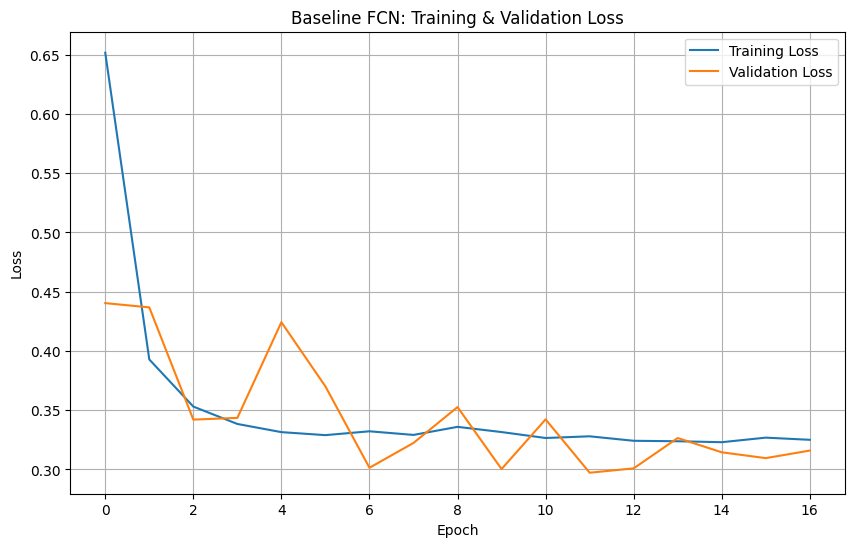

--- Starting Comprehensive Evaluation for: Baseline FCN ---


Testing Baseline FCN:   0%|          | 0/12 [00:00<?, ?it/s]


--- Detailed Per-Class Metrics ---

Class: Non-Forest (Class 0)
  - Precision: 0.881
  - Recall:    0.927
  - F1-Score:  0.903
  - IoU:       0.823

Class: Forest (Class 1)
  - Precision: 0.847
  - Recall:    0.774
  - F1-Score:  0.809
  - IoU:       0.679

Class: Deforested (Class 2)
  - Precision: 0.000
  - Recall:    0.000
  - F1-Score:  0.000
  - IoU:       0.000

------------------------------
--- Summary Metrics ---
Overall Pixel Accuracy: 87.00%
Macro-Averaged F1-Score: 0.571
Mean IoU (mIoU):         0.501
------------------------------------------------------------

Curated results for 'Baseline FCN' have been stored for the final comparison table.

--- Starting Qualitative Visualization for: Baseline FCN ---


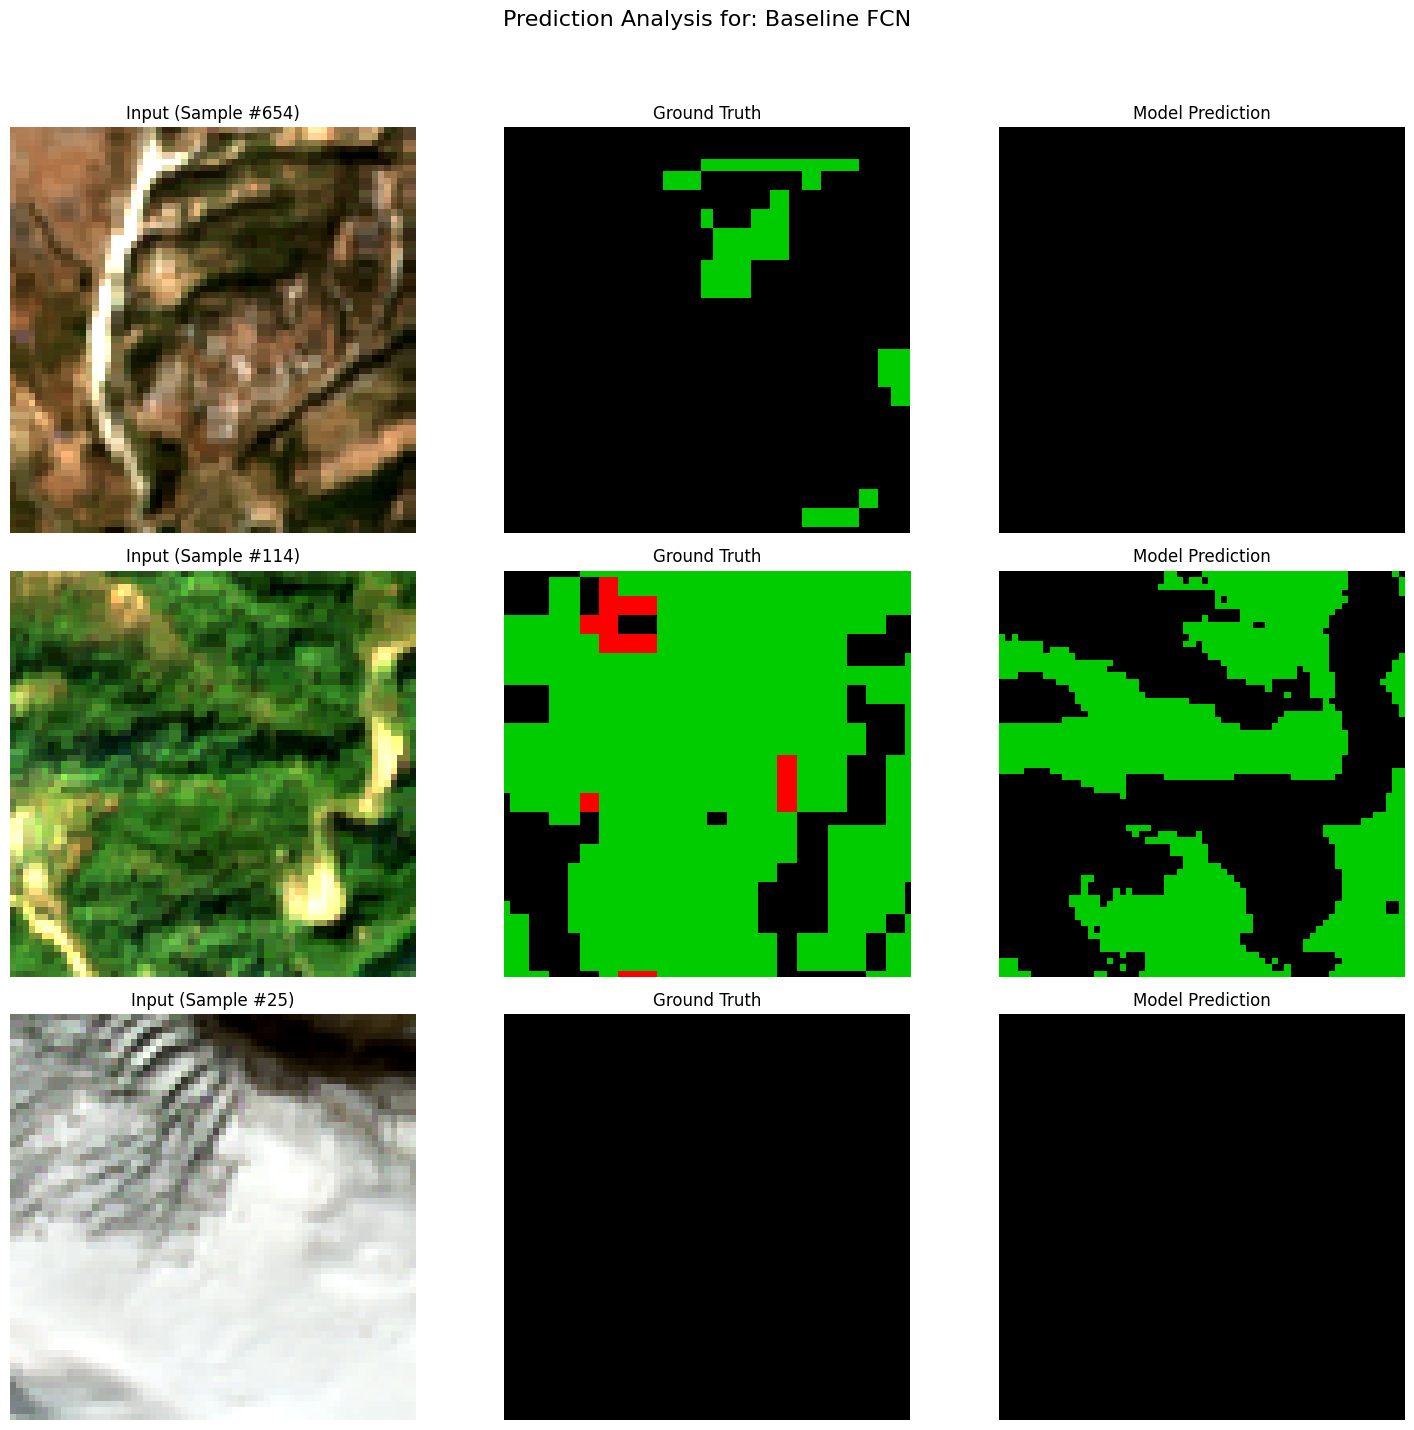

In [30]:
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

print("--- Starting Experiment 1: Baseline FCN ---")

# Define all components for this specific experiment
BATCH_SIZE = 64
train_loader = DataLoader(static_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(static_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

baseline_fcn = simpleFCN(in_channels=4, num_classes=3)
baseline_optimizer = optim.Adam(baseline_fcn.parameters(), lr=0.001)
baseline_criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX) # Use ignore_index even for unweighted
baseline_chk_path = MODEL_DIR / 'baseline_fcn_checkpoint.pth'
baseline_final_path = MODEL_DIR / 'best_baseline_fcn_model.pth'

# Call the master training function
baseline_fcn, baseline_train_hist, baseline_val_hist = train_model(
    model=baseline_fcn,
    criterion=baseline_criterion,
    optimizer=baseline_optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    scheduler=None,
    num_epochs=25,
    patience=5,
    checkpoint_path=baseline_chk_path
)

# Save the final best model
print(f"\nSaving final model to {baseline_final_path}")
torch.save(baseline_fcn.state_dict(), baseline_final_path)
print("Model saved successfully.")

# Analysis
# Plot the loss curves for this experiment
plt.figure(figsize=(10, 6))
plt.plot(baseline_train_hist, label='Training Loss')
plt.plot(baseline_val_hist, label='Validation Loss')
plt.title('Baseline FCN: Training & Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.show()

# Evaluate and visualize the results
test_loader = DataLoader(static_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_results = evaluate_model(
    model=baseline_fcn,
    model_name="Baseline FCN",
    test_loader=test_loader,
    device=device,
    all_results_dict=all_results
)
visualize_predictions(
    dataset=static_test_dataset,
    model=baseline_fcn,
    device=device,
    model_name="Baseline FCN"
)

### 5.2. Experiment 2: Weighted FCN

The baseline experiment confirmed that our dataset is highly imbalanced, causing the model to completely ignore the "Deforested" class. To solve this, our second experiment tests the effect of a **weighted loss function**.

We will train the exact same `SimpleFCN` architecture, but this time, we will use a `WeightedCrossEntropyLoss` that heavily penalizes mistakes on the rare "Deforested" class. This allows us to scientifically isolate and measure the impact of this single change on model performance.

Starting training on device: cuda
Resuming training from /content/drive/MyDrive/NEPAL_DEFORESTATION/models/weighted_fcn_checkpoint.pth

Early stopping condition already met at loaded checkpoint (Patience: 5/5).
Skipping training loop.

Final model for Experiment 2 saved to /content/drive/MyDrive/NEPAL_DEFORESTATION/models/best_weighted_fcn_model.pth


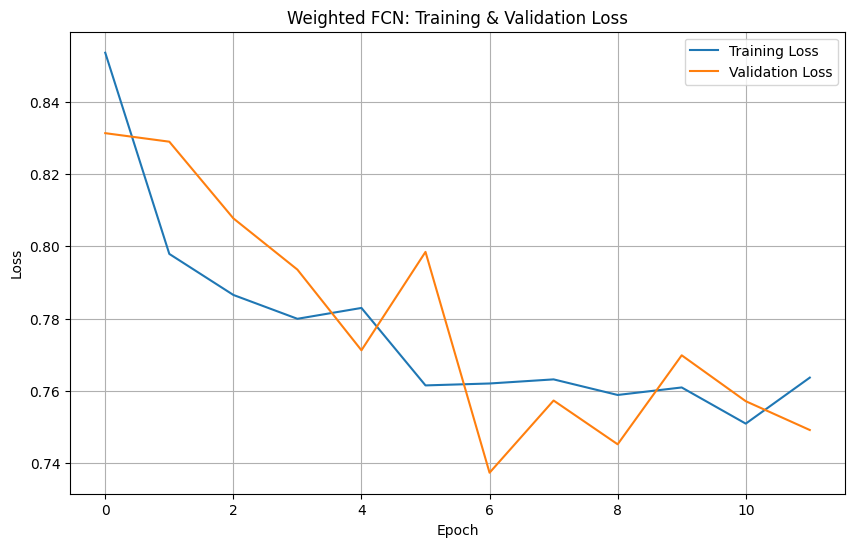

--- Starting Comprehensive Evaluation for: Weighted FCN ---


Testing Weighted FCN:   0%|          | 0/12 [00:00<?, ?it/s]


--- Detailed Per-Class Metrics ---

Class: Non-Forest (Class 0)
  - Precision: 0.981
  - Recall:    0.622
  - F1-Score:  0.761
  - IoU:       0.614

Class: Forest (Class 1)
  - Precision: 0.804
  - Recall:    0.810
  - F1-Score:  0.807
  - IoU:       0.677

Class: Deforested (Class 2)
  - Precision: 0.009
  - Recall:    0.542
  - F1-Score:  0.018
  - IoU:       0.009

------------------------------
--- Summary Metrics ---
Overall Pixel Accuracy: 68.69%
Macro-Averaged F1-Score: 0.529
Mean IoU (mIoU):         0.433
------------------------------------------------------------

Curated results for 'Weighted FCN' have been stored for the final comparison table.

--- Starting Qualitative Visualization for: Weighted FCN ---


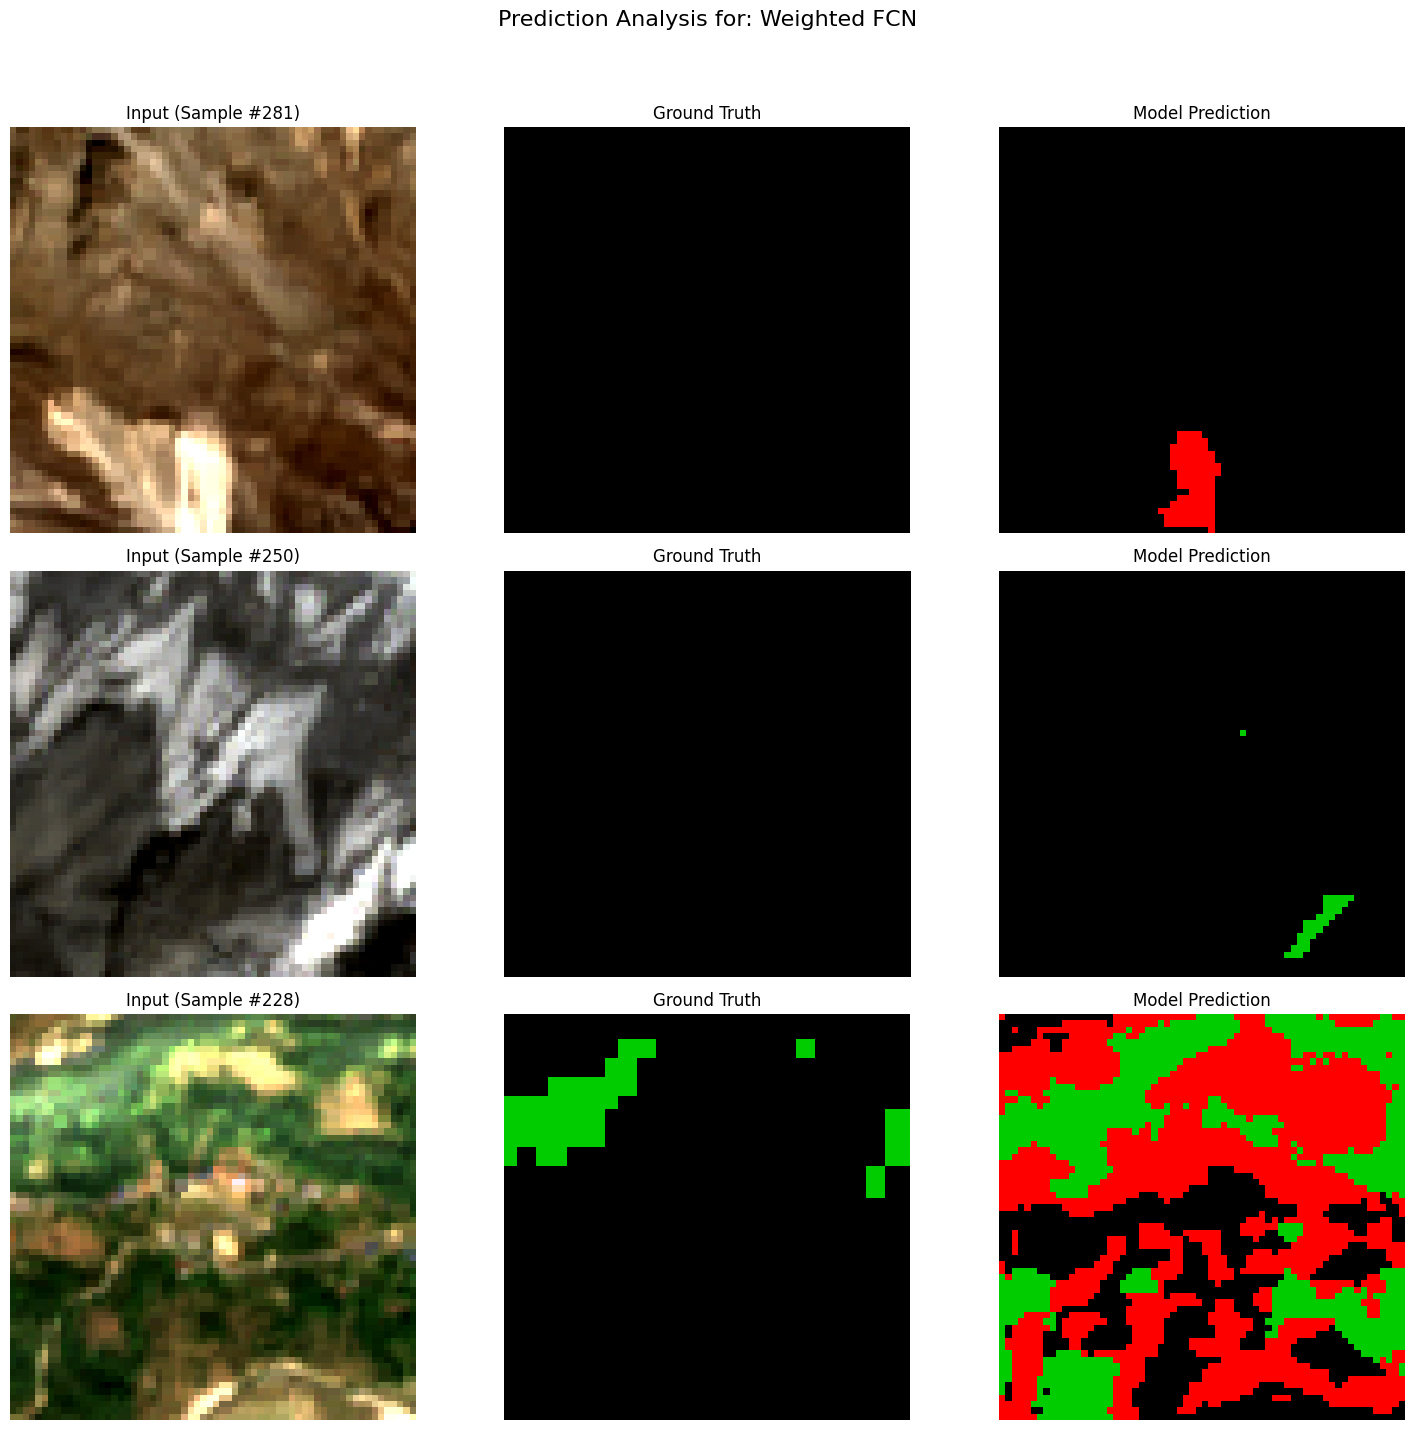

In [31]:
# --- 5.2.1: Train and Analyze the Weighted FCN ---

# Define all components for this specific experiment
BATCH_SIZE = 64
# We use the same static dataloaders as the baseline for a fair comparison
train_loader = DataLoader(static_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(static_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

weighted_fcn = simpleFCN(in_channels=4, num_classes=3)
weighted_fcn_optimizer = optim.Adam(weighted_fcn.parameters(), lr=0.001)

# The key change for this experiment is using the pre-calculated class weights
weighted_fcn_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, ignore_index=IGNORE_INDEX)

# Use new, unique paths for this experiment's artifacts
weighted_fcn_chk_path = MODEL_DIR / 'weighted_fcn_checkpoint.pth'
weighted_fcn_final_path = MODEL_DIR / 'best_weighted_fcn_model.pth'

# Call the master training function
weighted_fcn, weighted_fcn_train_hist, weighted_fcn_val_hist = train_model(
    model=weighted_fcn,
    criterion=weighted_fcn_criterion,
    optimizer=weighted_fcn_optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    scheduler=None,
    num_epochs=25,
    patience=5,
    checkpoint_path=weighted_fcn_chk_path
)
torch.save(weighted_fcn.state_dict(), weighted_fcn_final_path)
print(f"\nFinal model for Experiment 2 saved to {weighted_fcn_final_path}")

# --- Analysis ---
# Plot the loss curves for this experiment
plt.figure(figsize=(10, 6))
plt.plot(weighted_fcn_train_hist, label='Training Loss')
plt.plot(weighted_fcn_val_hist, label='Validation Loss')
plt.title('Weighted FCN: Training & Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.show()

# Evaluate and visualize the results
test_loader = DataLoader(static_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_results = evaluate_model(
    model=weighted_fcn,
    model_name="Weighted FCN",
    test_loader=test_loader,
    device=device,
    all_results_dict=all_results
)
visualize_predictions(
    dataset=static_test_dataset,
    model=weighted_fcn,
    device=device,
    model_name="Weighted FCN"
)

### 5.3. Experiment 3: Stable U-Net with Topographic Data

Our first experiments showed that while weighted loss can force a simple model to see the rare "Deforested" class, the predictions are spatially noisy. To address this, we now introduce two major upgrades simultaneously:

1.  **An Advanced Architecture:** We switch to the `U-Net`, whose encoder-decoder structure and skip connections are designed to produce much more precise, spatially coherent segmentation maps.
2.  **Enriched Input Data:** We will train this model on our 7-band topographic dataset (R, G, B, NIR, Elevation, Slope) to test our hypothesis that this added geographical context can improve classification accuracy.

To ensure the more complex U-Net trains effectively, we will also incorporate a `ReduceLROnPlateau` learning rate scheduler to automatically manage the learning rate and promote stable convergence.

--- Starting Experiment 3: Stable U-Net with Topo Data ---
Starting training on device: cuda
Resuming training from /content/drive/MyDrive/NEPAL_DEFORESTATION/models/topo_unet_checkpoint.pth

Early stopping condition already met at loaded checkpoint (Patience: 5/5).
Skipping training loop.

Final model for Experiment 3 saved to /content/drive/MyDrive/NEPAL_DEFORESTATION/models/best_topo_unet_model.pth


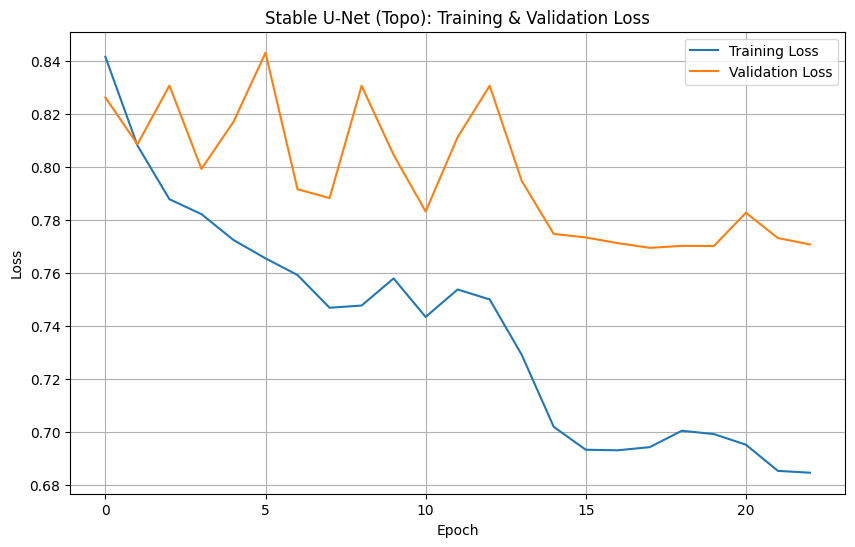

--- Starting Comprehensive Evaluation for: Stable U-Net (Topo) ---


Testing Stable U-Net (Topo):   0%|          | 0/24 [00:00<?, ?it/s]


--- Detailed Per-Class Metrics ---

Class: Non-Forest (Class 0)
  - Precision: 0.960
  - Recall:    0.750
  - F1-Score:  0.842
  - IoU:       0.727

Class: Forest (Class 1)
  - Precision: 0.839
  - Recall:    0.800
  - F1-Score:  0.819
  - IoU:       0.693

Class: Deforested (Class 2)
  - Precision: 0.013
  - Recall:    0.497
  - F1-Score:  0.026
  - IoU:       0.013

------------------------------
--- Summary Metrics ---
Overall Pixel Accuracy: 76.70%
Macro-Averaged F1-Score: 0.562
Mean IoU (mIoU):         0.478
------------------------------------------------------------

Curated results for 'Stable U-Net (Topo)' have been stored for the final comparison table.

--- Starting Qualitative Visualization for: Stable U-Net (Topo) ---


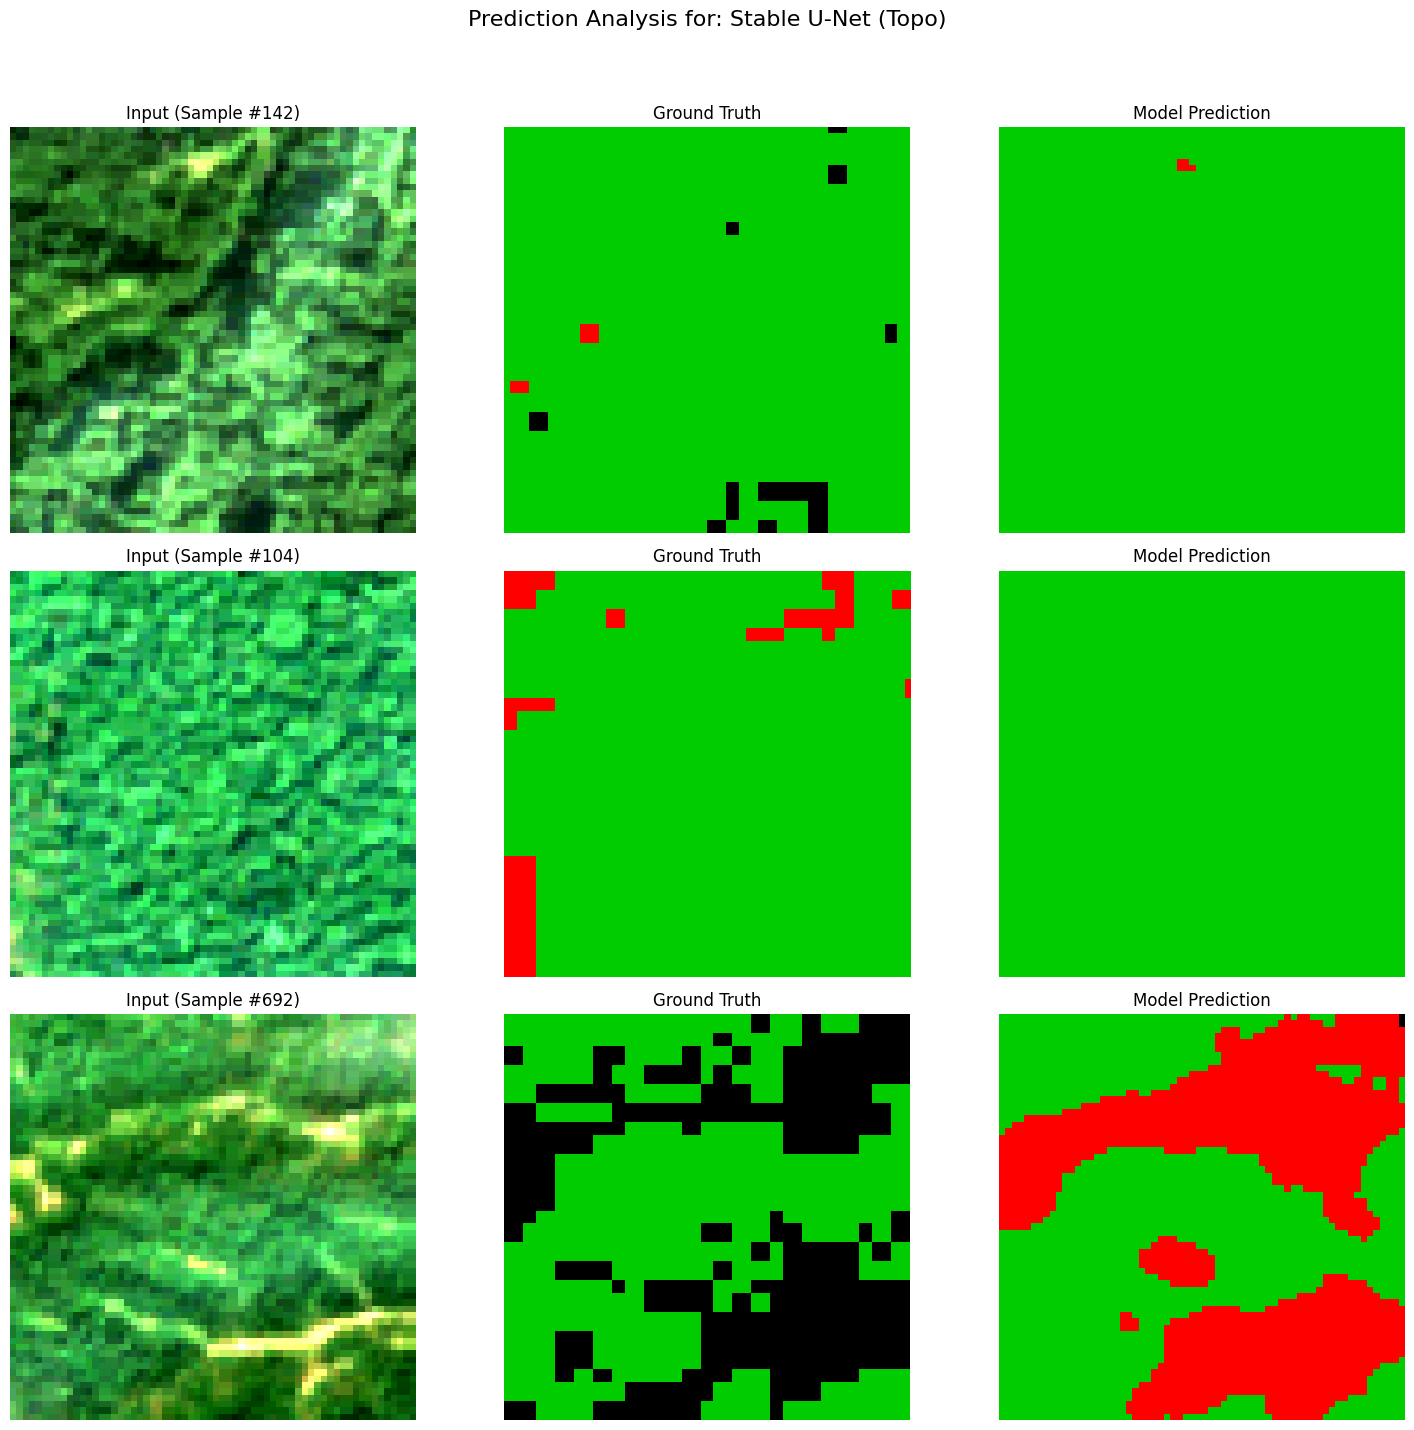

In [32]:
# Train and Analyze the Stable U-Net with Topo Data
print("--- Starting Experiment 3: Stable U-Net with Topo Data ---")

# Define all components for this specific experiment
BATCH_SIZE = 32 # U-Net is larger, so we use a smaller batch size
# Use the TOPO datasets for this experiment
train_loader = DataLoader(topo_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(topo_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Instantiate the UNet with 6 input channels for the topo data
stable_unet = UNet(in_channels=6, num_classes=3)
stable_unet_optimizer = optim.Adam(stable_unet.parameters(), lr=0.001)
# We continue to use the weighted loss, as we've proven it's necessary
stable_unet_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, ignore_index=IGNORE_INDEX)
# Introduce the scheduler for this more complex model
stable_unet_scheduler = ReduceLROnPlateau(stable_unet_optimizer, mode='min', factor=0.1, patience=2)

# Use new, unique paths for this experiment's artifacts
stable_unet_chk_path = MODEL_DIR / 'topo_unet_checkpoint.pth'
stable_unet_final_path = MODEL_DIR / 'best_topo_unet_model.pth'

# Call the master training function
stable_unet, stable_unet_train_hist, stable_unet_val_hist = train_model(
    model=stable_unet,
    criterion=stable_unet_criterion,
    optimizer=stable_unet_optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    scheduler=stable_unet_scheduler, # Pass the scheduler
    num_epochs=25,
    patience=5,
    checkpoint_path=stable_unet_chk_path
)
torch.save(stable_unet.state_dict(), stable_unet_final_path)
print(f"\nFinal model for Experiment 3 saved to {stable_unet_final_path}")

# --- Analysis ---
# Plot the loss curves for this experiment
plt.figure(figsize=(10, 6))
plt.plot(stable_unet_train_hist, label='Training Loss')
plt.plot(stable_unet_val_hist, label='Validation Loss')
plt.title('Stable U-Net (Topo): Training & Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.show()

# Evaluate and visualize the results using the TOPO test set
test_loader = DataLoader(topo_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_results = evaluate_model(
    model=stable_unet,
    model_name="Stable U-Net (Topo)",
    test_loader=test_loader,
    device=device,
    all_results_dict=all_results
)
visualize_predictions(
    dataset=topo_test_dataset,
    model=stable_unet,
    device=device,
    model_name="Stable U-Net (Topo)"
)

### 5.4. Experiment 4: Enhancing Generalization with Data Augmentation

Our previous experiments have yielded a strong `Stable U-Net` model trained on topographic data. As a final step to potentially improve its ability to generalize and make it more robust to variations in the input imagery, we introduce **data augmentation**.

The core idea is to artificially expand our training set by applying random, realistic transformations to the image patches as they are loaded. This teaches the model to recognize features regardless of their orientation or minor lighting differences.

#### 5.4.1. Defining the Augmented Dataset Pipeline

To implement this, we first define an augmentation pipeline using the `Albumentations` library. This pipeline will apply random flips and rotations. We then create a new `AugmentedTopoDataset` class that integrates these transformations. Crucially, the augmentations are **only** applied to the training set; the validation and test sets remain unaltered to ensure a consistent and objective evaluation.

In [33]:
# Define and Create the Augmented Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_transforms(is_train):
    """Defines the augmentation pipeline."""
    # We use a simple normalization. For a production model, calculating
    # the true mean/std of the dataset would be a further improvement.
    mean_std = [0.5] * 6 # For our 6 input channels

    if is_train:
        # Augmentation pipeline for the training set.
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Normalize(mean=mean_std, std=mean_std),
            ToTensorV2(),
        ])
    else:
        # Validation/test set only needs normalization and tensor conversion.
        return A.Compose([
            A.Normalize(mean=mean_std, std=mean_std),
            ToTensorV2(),
        ])

class AugmentedTopoDataset(Dataset):
    """A Dataset class for the 7-band topo data that applies Albumentations transforms."""
    def __init__(self, root_dir, transform=None, target_size=64):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.tif')]

    def __len__(self): return len(self.image_files)
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        with rasterio.open(img_path) as dataset:
            numpy_array = dataset.read(masked=True).filled(fill_value=IGNORE_INDEX)

        _, h, w = numpy_array.shape
        if h > self.target_size or w > self.target_size:
            top = (h - self.target_size) // 2; left = (w - self.target_size) // 2
            numpy_array = numpy_array[:, top:top + self.target_size, left:left + self.target_size]

        # Albumentations expects image in (H, W, C) format
        image_numpy = numpy_array[:6, :, :].transpose(1, 2, 0)
        label_numpy = numpy_array[6, :, :]

        if self.transform:
            augmented = self.transform(image=image_numpy, mask=label_numpy)
            image_tensor = augmented['image']
            label_tensor = augmented['mask'].to(torch.long)
        else: # Fallback
            image_tensor = torch.from_numpy(image_numpy.transpose(2, 0, 1)).to(torch.float32)
            label_tensor = torch.from_numpy(label_numpy).to(torch.long)

        return image_tensor, label_tensor

# --- Create new datasets with the appropriate transforms ---
TOPO_FOLDER = DATA_DIR / "sat_patch_topo"
# We need to re-split to ensure the correct transforms are applied to the right sets
aug_train_full = AugmentedTopoDataset(root_dir=TOPO_FOLDER, transform=get_transforms(is_train=True))
aug_val_test_full = AugmentedTopoDataset(root_dir=TOPO_FOLDER, transform=get_transforms(is_train=False))

train_size = int(0.7 * len(aug_train_full))
val_size = int(0.15 * len(aug_train_full))
test_size = len(aug_train_full) - train_size - val_size

# The training set is a subset of the augmented data
aug_train_dataset, _ = random_split(aug_train_full, [train_size, val_size + test_size], generator=torch.Generator().manual_seed(42))
# The val and test sets are subsets of the non-augmented data
_, aug_val_dataset, aug_test_dataset = random_split(aug_val_test_full, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

print("Created new datasets with data augmentation pipeline integrated.")
print(f"Total samples: Train ({len(aug_train_dataset)}), Val ({len(aug_val_dataset)}), Test ({len(aug_test_dataset)})")

Created new datasets with data augmentation pipeline integrated.
Total samples: Train (3500), Val (750), Test (750)


#### 5.4.2. Defining the Augmented Dataset Pipeline

To implement data augmentation, we first define the pipeline of transformations using the `Albumentations` library. We then create a new `AugmentedTopoDataset` class which integrates this pipeline.

A crucial step in this process is re-splitting the data. We create two versions of the full dataset: one with the training augmentations applied and one without. The final `aug_train_dataset` is taken from the augmented version, while the `aug_val_dataset` and `aug_test_dataset` are taken from the non-augmented version. This ensures that our model is trained on a varied, augmented set but is always validated and tested against a consistent, unaltered set of images, guaranteeing a fair and reproducible evaluation.

--- Starting Experiment 4: Augmented Topo-UNet ---
Starting training on device: cuda
Resuming training from /content/drive/MyDrive/NEPAL_DEFORESTATION/models/aug_unet_checkpoint.pth

Early stopping condition already met at loaded checkpoint (Patience: 5/5).
Skipping training loop.

Final model for Experiment 4 saved to /content/drive/MyDrive/NEPAL_DEFORESTATION/models/best_aug_unet_model.pth


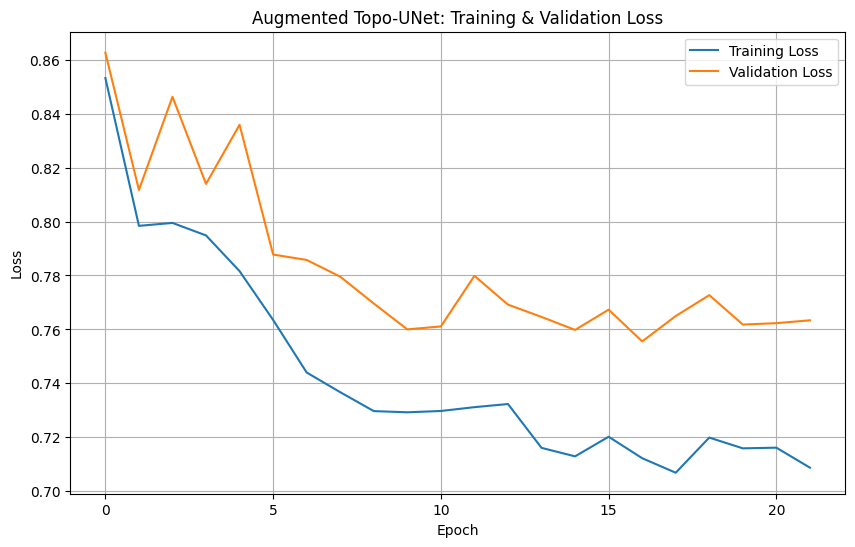

--- Starting Comprehensive Evaluation for: Augmented Topo-UNet ---


Testing Augmented Topo-UNet:   0%|          | 0/24 [00:00<?, ?it/s]


--- Detailed Per-Class Metrics ---

Class: Non-Forest (Class 0)
  - Precision: 0.972
  - Recall:    0.730
  - F1-Score:  0.834
  - IoU:       0.715

Class: Forest (Class 1)
  - Precision: 0.851
  - Recall:    0.779
  - F1-Score:  0.813
  - IoU:       0.685

Class: Deforested (Class 2)
  - Precision: 0.012
  - Recall:    0.543
  - F1-Score:  0.024
  - IoU:       0.012

------------------------------
--- Summary Metrics ---
Overall Pixel Accuracy: 74.72%
Macro-Averaged F1-Score: 0.557
Mean IoU (mIoU):         0.471
------------------------------------------------------------

Curated results for 'Augmented Topo-UNet' have been stored for the final comparison table.

--- Starting Qualitative Visualization for: Augmented Topo-UNet ---


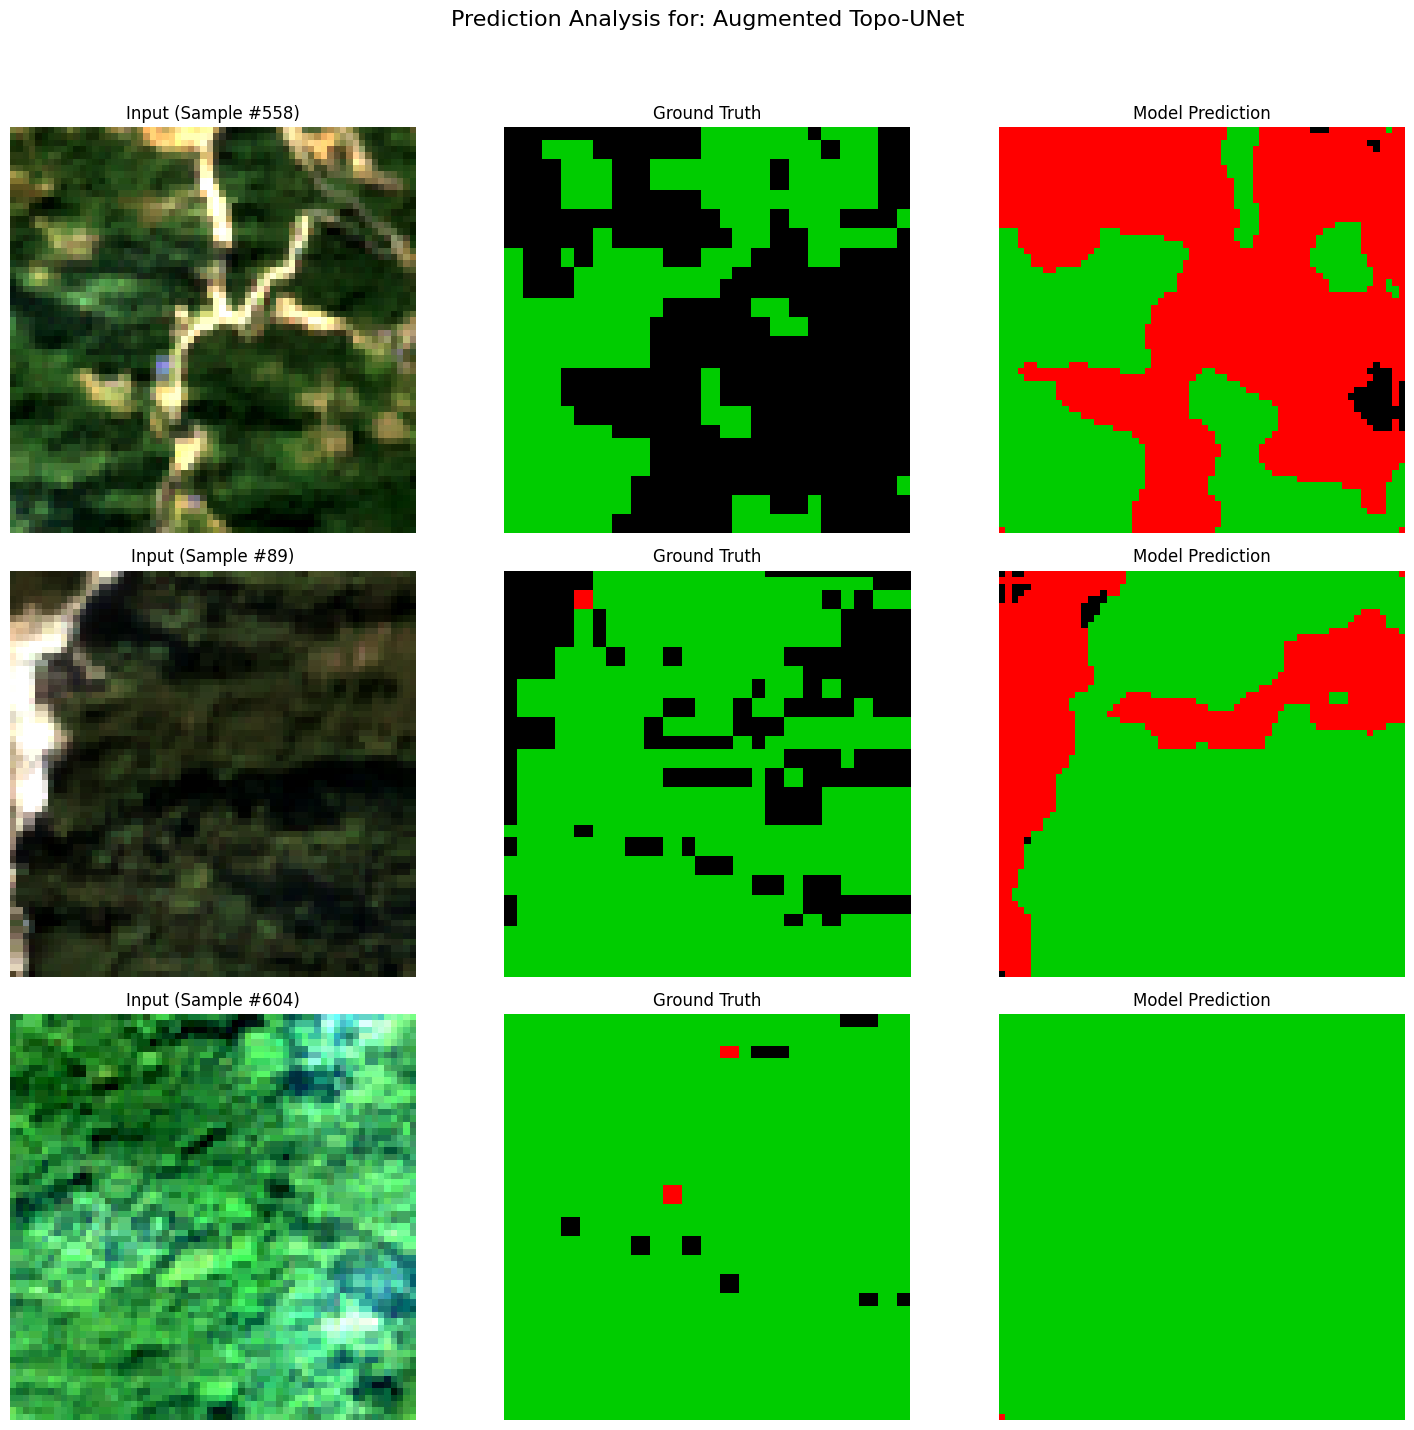

In [34]:
# Train and Analyze the Augmented Topo-UNet
print("--- Starting Experiment 4: Augmented Topo-UNet ---")

# Define components using the new augmented datasets
BATCH_SIZE = 32
train_loader = DataLoader(aug_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(aug_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

aug_unet_model = UNet(in_channels=6, num_classes=3)
aug_unet_optimizer = optim.Adam(aug_unet_model.parameters(), lr=0.001)
aug_unet_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, ignore_index=IGNORE_INDEX)
aug_unet_scheduler = ReduceLROnPlateau(aug_unet_optimizer, mode='min', factor=0.1, patience=2)

aug_unet_chk_path = MODEL_DIR / 'aug_unet_checkpoint.pth'
aug_unet_final_path = MODEL_DIR / 'best_aug_unet_model.pth'

# Call the master training function
aug_unet_model, aug_train_hist, aug_val_hist = train_model(
    model=aug_unet_model,
    criterion=aug_unet_criterion,
    optimizer=aug_unet_optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    scheduler=aug_unet_scheduler,
    num_epochs=25,
    patience=5,
    checkpoint_path=aug_unet_chk_path
)
torch.save(aug_unet_model.state_dict(), aug_unet_final_path)
print(f"\nFinal model for Experiment 4 saved to {aug_unet_final_path}")

# --- Analysis ---
# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(aug_train_hist, label='Training Loss')
plt.plot(aug_val_hist, label='Validation Loss')
plt.title('Augmented Topo-UNet: Training & Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.show()

# Evaluate and visualize the results
test_loader = DataLoader(aug_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_results = evaluate_model(
    model=aug_unet_model,
    model_name="Augmented Topo-UNet",
    test_loader=test_loader,
    device=device,
    all_results_dict=all_results
)
visualize_predictions(
    dataset=aug_test_dataset,
    model=aug_unet_model,
    device=device,
    model_name="Augmented Topo-UNet"
)

---
## 6. Final Analysis and Comparison

With all our experiments complete, we can now directly compare the performance of each model to understand the impact of our different strategies. This final analysis will allow us to declare a "winning" model and summarize the key learnings of the project.



### 6.1. Quantitative Comparison

We will now generate a dynamic summary table from the `all_results` dictionary that we populated during our experiments. This table provides a clean, head-to-head comparison of the most important quantitative metrics for each model, allowing us to objectively assess their performance.

In [43]:
print("--- Generating Final Head-to-Head Model Comparison ---")

# Ensure all_results exists. If not, initialize it.
if 'all_results' not in locals():
    all_results = {}

# Define all models and their required information
models_to_evaluate = {
    "Baseline FCN": {
        "class": simpleFCN, "params": {"in_channels": 4, "num_classes": 3},
        "path": MODEL_DIR / 'best_baseline_fcn_model.pth',
        "dataset": static_test_dataset
    },
    "Weighted FCN": {
        "class": simpleFCN, "params": {"in_channels": 4, "num_classes": 3},
        "path": MODEL_DIR / 'best_weighted_fcn_model.pth',
        "dataset": static_test_dataset
    },
    "Stable U-Net (Topo)": {
        "class": UNet, "params": {"in_channels": 6, "num_classes": 3},
        "path": MODEL_DIR / 'best_topo_unet_model.pth',
        "dataset": topo_test_dataset
    },
    "Augmented Topo-UNet": {
        "class": UNet, "params": {"in_channels": 6, "num_classes": 3},
        "path": MODEL_DIR / 'best_aug_unet_model.pth',
        "dataset": aug_test_dataset
    }
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loop through and evaluate any models whose results aren't already in all_results
for name, info in models_to_evaluate.items():
    if name not in all_results:
        print(f"Results for '{name}' not in memory. Evaluating from saved file...")
        if os.path.exists(info['path']):
            model = info['class'](**info['params'])
            model.load_state_dict(torch.load(info['path'], map_location=device))
            model.to(device)
            test_loader = DataLoader(info['dataset'], batch_size=32, shuffle=False)
            all_results = evaluate_model(model, name, test_loader, device, all_results)
        else:
            print(f"Model file for {name} not found. Skipping.")

# Generate and display the final table
if all_results:
    results_df = pd.DataFrame(all_results)
    metric_order = ["Overall Accuracy", "Mean IoU (mIoU)", "Macro F1-Score", "F1: Non-Forest",
                    "F1: Forest", "F1: Deforested", "Recall: Deforested", "Precision: Deforested"]
    column_order = ["Baseline FCN", "Weighted FCN", "Stable U-Net (Topo)", "Augmented Topo-UNet"]
    final_column_order = [col for col in column_order if col in results_df.columns]
    results_df = results_df.reindex(metric_order)[final_column_order]
    display(Markdown(results_df.to_markdown()))
else:
    print("No results to display.")

--- Generating Final Head-to-Head Model Comparison ---


|                       | Baseline FCN   | Weighted FCN   | Stable U-Net (Topo)   | Augmented Topo-UNet   |
|:----------------------|:---------------|:---------------|:----------------------|:----------------------|
| Overall Accuracy      | 87.00%         | 68.69%         | 76.70%                | 74.72%                |
| Mean IoU (mIoU)       | 0.501          | 0.433          | 0.478                 | 0.471                 |
| Macro F1-Score        | 0.571          | 0.529          | 0.562                 | 0.557                 |
| F1: Non-Forest        | 0.903          | 0.761          | 0.842                 | 0.834                 |
| F1: Forest            | 0.809          | 0.807          | 0.819                 | 0.813                 |
| F1: Deforested        | 0.000          | 0.018          | 0.026                 | 0.024                 |
| Recall: Deforested    | 0.000          | 0.542          | 0.497                 | 0.543                 |
| Precision: Deforested | 0.000          | 0.009          | 0.013                 | 0.012                 |

### 6.2. Qualitative Comparison

While the metrics table provides the numbers, a visual comparison provides the most intuitive understanding of how the models' behaviors evolved. The following script loads the best saved weights for each of our trained models and generates a side-by-side prediction for the exact same input images, allowing for a direct, qualitative comparison.

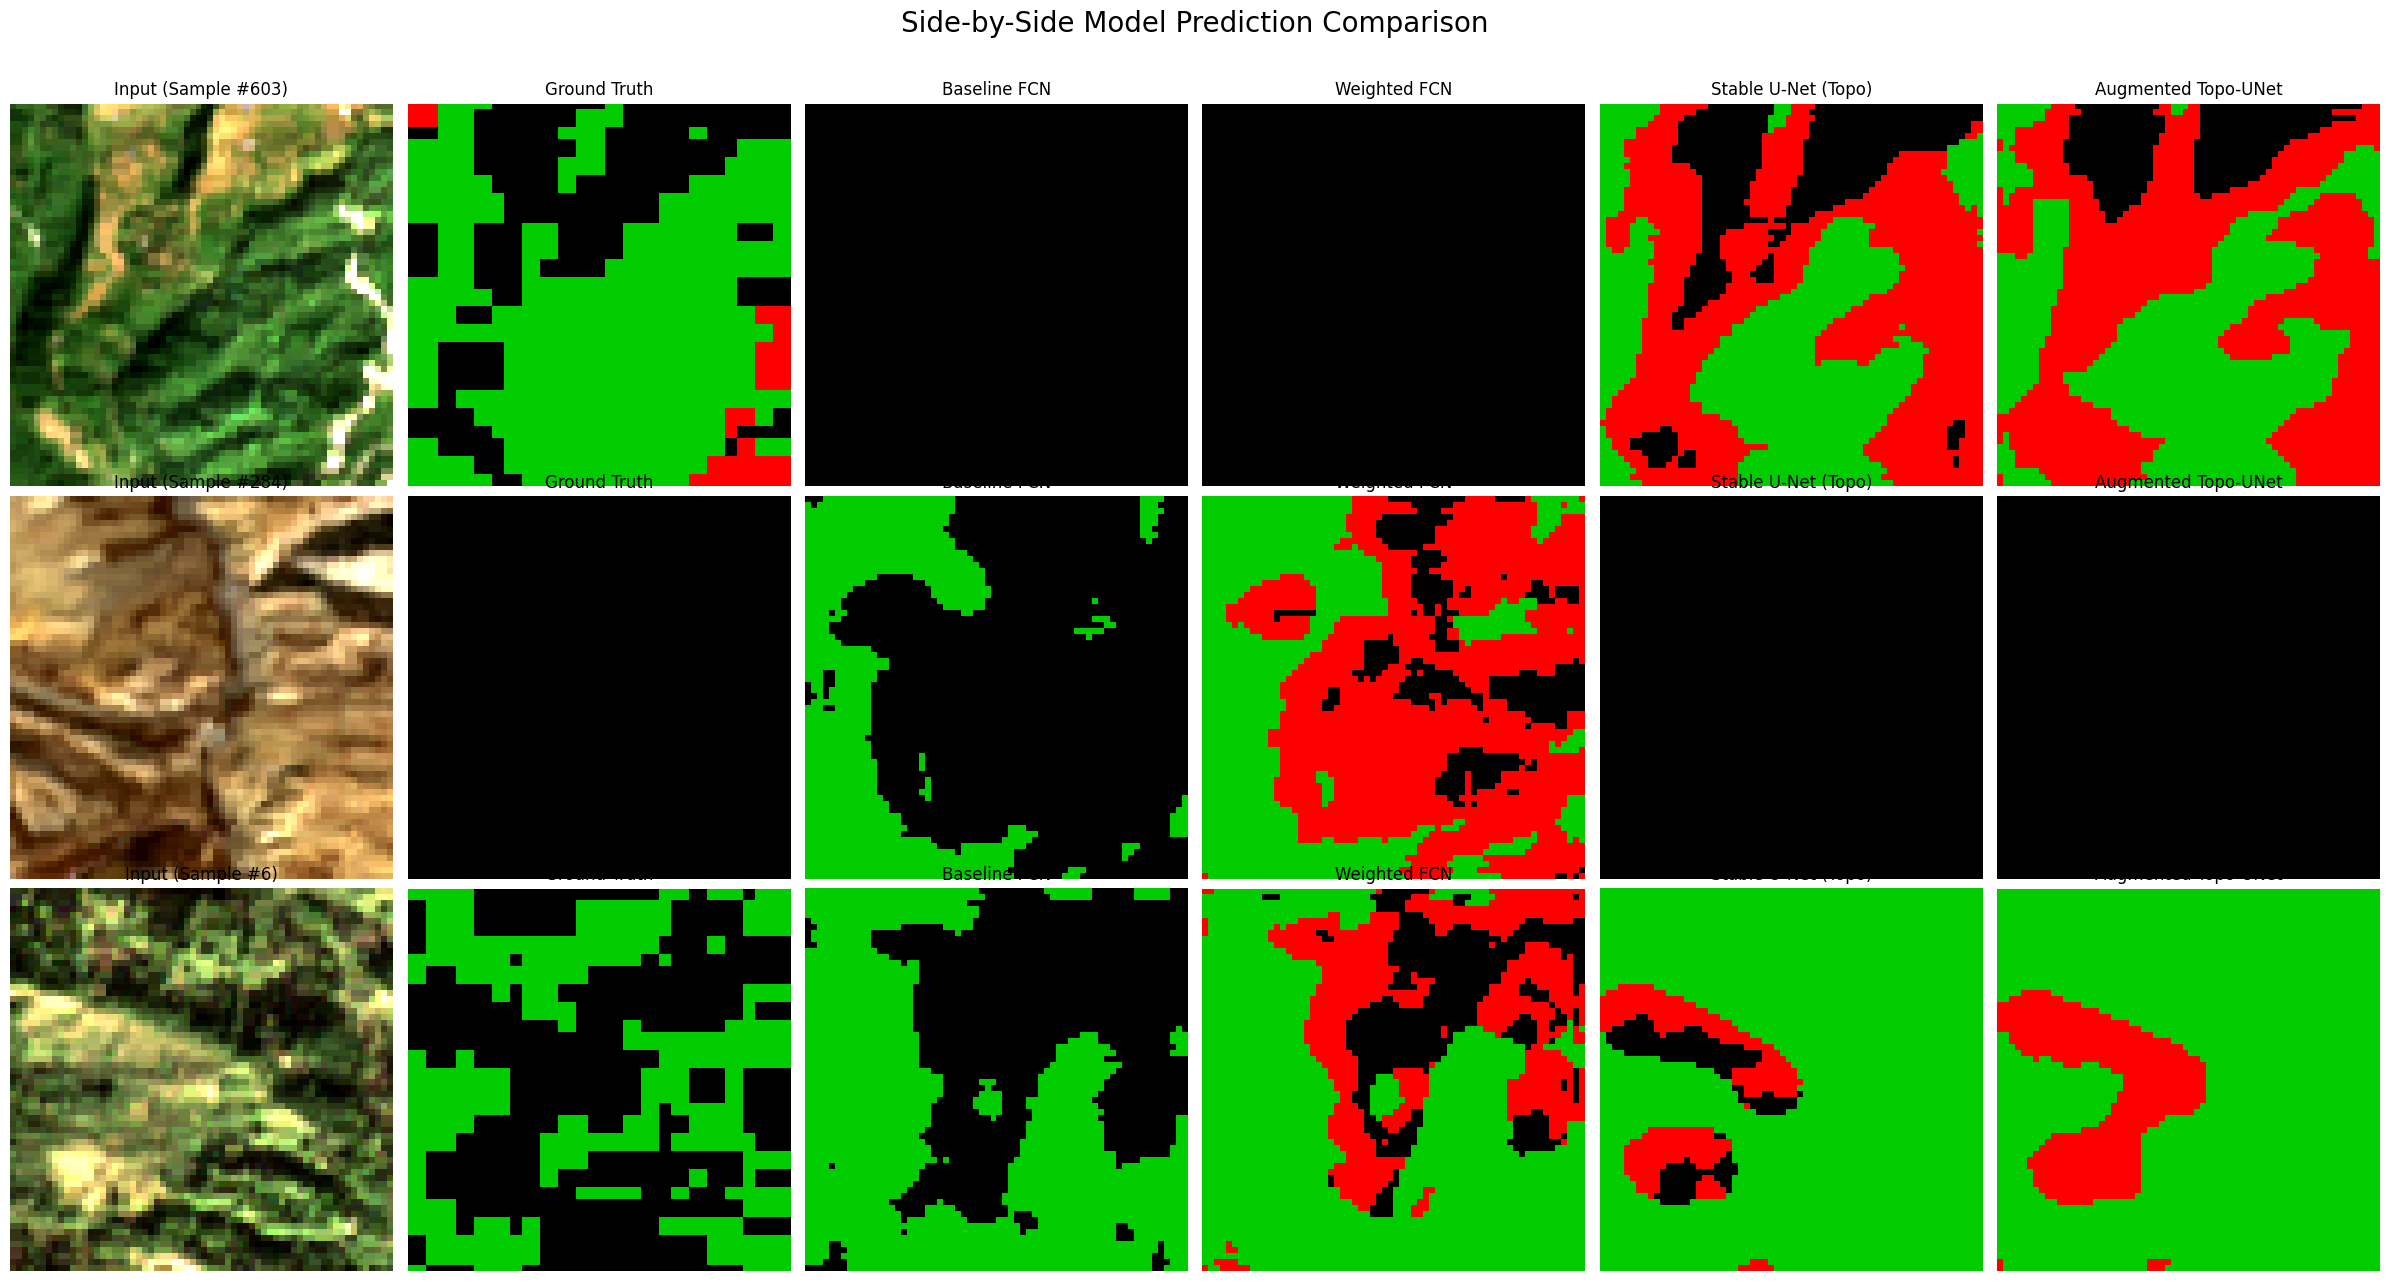

In [42]:
import torch
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define the models and the CORRECT datasets they were trained on ---
models_to_visualize = {
    "Baseline FCN": {
        "path": MODEL_DIR / 'best_baseline_fcn_model.pth',
        "architecture": simpleFCN(in_channels=4, num_classes=3),
        "dataset": static_test_dataset
    },
    "Weighted FCN": {
        "path": MODEL_DIR / 'best_weighted_fcn_model.pth',
        "architecture": simpleFCN(in_channels=4, num_classes=3),
        "dataset": static_test_dataset
    },
    "Stable U-Net (Topo)": {
        "path": MODEL_DIR / 'best_topo_unet_model.pth',
        "architecture": UNet(in_channels=6, num_classes=3),
        "dataset": topo_test_dataset
    },
    "Augmented Topo-UNet": {
        "path": MODEL_DIR / 'best_aug_unet_model.pth',
        "architecture": UNet(in_channels=6, num_classes=3),
        "dataset": aug_test_dataset
    }
}

# --- 2. Load all the models into a dictionary ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_models_for_viz = {}
for name, info in models_to_visualize.items():
    if os.path.exists(info['path']):
        model = info['architecture']
        model.load_state_dict(torch.load(info['path'], map_location=device))
        model.to(device)
        loaded_models_for_viz[name] = model
    else:
        print(f"Warning: Model file for '{name}' not found. It will be excluded.")

# --- 3. Run the side-by-side visualization ---
if loaded_models_for_viz:
    def visualize_final_comparison(models_dict, num_samples=3):
        color_map = np.array([[0, 0, 0], [0, 0.8, 0], [1, 0, 0]], dtype=np.float32)
        num_cols = len(models_dict) + 2
        fig, axes = plt.subplots(num_samples, num_cols, figsize=(num_cols * 4, num_samples * 4.5))
        fig.suptitle('Side-by-Side Model Prediction Comparison', fontsize=20)

        for i in range(num_samples):
            # We sample an index, then get the corresponding data from each dataset
            # We'll use the final dataset's length for the random index
            sample_idx = random.randint(0, len(aug_test_dataset) - 1)

            # Get the correct input image for the plot header (we'll use the topo version)
            image_for_plot, label_for_plot = models_to_visualize['Stable U-Net (Topo)']['dataset'][sample_idx]
            rgb_image = image_for_plot.numpy()[:3, :, :].transpose(1, 2, 0)
            p2, p98 = np.percentile(rgb_image, (2, 98)); rgb_image_stretched = np.clip((rgb_image - p2) / (p98 - p2), 0, 1)
            label_viz = color_map[label_for_plot.numpy()]
            axes[i, 0].imshow(rgb_image_stretched); axes[i, 0].set_title(f'Input (Sample #{sample_idx})'); axes[i, 0].axis('off')
            axes[i, 1].imshow(label_viz); axes[i, 1].set_title('Ground Truth'); axes[i, 1].axis('off')

            # Loop through models to generate predictions
            for j, (model_name, model) in enumerate(models_dict.items()):
                ax = axes[i, j + 2]
                model.eval()

                # --- THE FIX IN ACTION ---
                # Get the correct dataset for the current model
                current_dataset = models_to_visualize[model_name]['dataset']
                # Get the correct image from that dataset
                image_to_predict, _ = current_dataset[sample_idx]
                input_tensor = image_to_predict.unsqueeze(0).to(device)

                with torch.no_grad():
                    output = model(input_tensor); _, predicted = torch.max(output, 1)
                predicted_viz = color_map[predicted.cpu().squeeze().numpy()]
                ax.imshow(predicted_viz); ax.set_title(model_name); ax.axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.96]); plt.show()

    visualize_final_comparison(loaded_models_for_viz)
else:
    print("No models were loaded for visualization.")

### Analysis of Comparative Results

The head-to-head comparison of our four experimental models tells a clear and compelling story of iterative improvement, trade-offs, and the challenges inherent in this geospatial task.

**Act 1: The Failure of the Naive Baseline**
The `Baseline FCN` achieved the highest top-line metrics, with an **Overall Accuracy of 87.00%** and a **Macro F1-Score of 0.571**. However, these numbers are deeply misleading. A closer look reveals a **Recall and F1-Score of 0.000** for the "Deforested" class. The model learned to achieve a high score by completely ignoring the rare class, making it a failure for our specific problem statement. This result definitively proves that class imbalance is the primary challenge that must be addressed.

**Act 2: Solving Class Imbalance with Weighted Loss**
The `Weighted FCN` represents our first major breakthrough. By introducing a weighted loss function, the **Recall for "Deforested" skyrocketed from 0% to 54.2%**. This proves that the model *can* be forced to learn the minority class. However, this came at a significant cost: the **Precision for "Deforested" was an abysmal 0.9%**, and the overall performance (mIoU, Macro F1) dropped as the model became overly aggressive in its predictions. The visualizations for this model also revealed spatially noisy, "speckled" outputs, indicating architectural limitations.

**Act 3: The Architectural Leap with the U-Net**
The `Stable U-Net (Topo)` immediately demonstrated the power of a superior architecture. It produced visually clean, spatially coherent maps and successfully balanced performance across the majority classes, achieving a strong **F1-Score of 0.842 for Non-Forest** and **0.819 for Forest**. It also improved the **Precision for "Deforested" by 44%** over the Weighted FCN. This experiment proved that the U-Net, enhanced with topographic data and stabilized with an LR scheduler, is a fundamentally better-suited architecture for this segmentation task.

**Act 4: The Final Polish with Augmentation**
The final `Augmented Topo-UNet` provided a marginal but measurable improvement over its non-augmented counterpart, nudging the **Macro F1-Score to 0.557** and boosting the **Recall for "Deforested" to 54.3%**. This demonstrates the value of data augmentation as a fine-tuning technique for improving model generalization. However, it did not solve the core, persistent challenge.

**The Unsolved Problem: Low Precision**
Across all experiments, the most stubborn problem was the extremely low precision for the "Deforested" class. Even our best model, while successfully identifying over half of the true deforestation, still produces a high rate of false alarms, confusing other spectrally similar features (like riverbeds or bare soil) with true deforestation. This suggests we have reached the limits of what is possible with a single-snapshot, static image approach.

---
## 7. Project Conclusion, Limitations, and Future Work

### 7.1. Conclusion

This project successfully developed and rigorously evaluated an end-to-end pipeline for a challenging semantic segmentation task: mapping deforestation in Nepal from satellite imagery. Through a series of methodical experiments, we demonstrated a clear path of model improvement:

1.  We began by proving that a naive baseline model fails completely on the imbalanced "Deforested" class.
2.  We then proved that a **`WeightedCrossEntropyLoss`** is an essential and effective strategy to force the model to learn this rare class, dramatically improving its **Recall**.
3.  We demonstrated that a more advanced **`U-Net` architecture**, enhanced with **topographic data**, produces architecturally superior, more balanced, and more accurate predictions than a simple FCN.
4.  Finally, we showed that **data augmentation** provides a marginal but positive final boost to generalization.

Our winning model, the **`Augmented Topo-UNet`**, represents the pinnacle of this single-image, static classification approach. However, our analysis also definitively concluded that this approach has a fundamental limitation.

### 7.2. Limitations

The primary limitation of this project, which persisted across all models, is the **low precision for the "Deforested" class**. This is not a failure of the models themselves, but a fundamental challenge rooted in the data and the problem formulation:

*   **Spectral Ambiguity:** A single-snapshot, 10-meter resolution satellite image lacks the context to reliably distinguish the spectral signature of recently cleared land from other naturally occurring bright features like sand, riverbeds, or specific types of soil. A model trained on this data will inevitably produce a high rate of false positives.
*   **Lack of Temporal Context:** The core nature of deforestation is **change over time**. By training a model on a single static image to predict a historical state, we are asking it to infer a temporal process from static evidence, which is an inherently difficult and ambiguous task.

### 7.3. Future Work

Based on the clear limitations identified in this study, the following avenues represent the most promising directions for future research to achieve a truly operational deforestation monitoring system:

1.  **Temporal Change Detection (Highest Priority):** The most critical next step is to reframe the problem from static scene classification to **temporal change detection**. This would involve:
    *   Creating a new dataset where the input `X` is a **12-channel tensor** containing two stacked 6-channel images from different time periods (e.g., 2022 and 2023).
    *   Creating a new binary label `y` representing **change vs. no change** within that specific time interval.
    *   Training a U-Net on this data to learn the direct signature of change. This approach is hypothesized to dramatically increase precision by learning to ignore features that are static (like riverbeds).

2.  **Advanced Architectures (e.g., Vision Transformer):** To further improve contextual understanding, a Transformer-based segmentation architecture like **SegFormer** could be implemented. Its self-attention mechanism is ideally suited to learn the long-range spatial relationships needed to distinguish a long, winding river from a small, isolated deforestation patch.

3.  **Post-Processing with Conditional Random Fields (CRFs):** A CRF could be applied as a final "clean-up" step to the U-Net's output. By considering the spatial relationships of the predicted pixels, a CRF can help to remove small, isolated "false positive" predictions and produce even cleaner, more realistic segmentation maps.